# Solver Comparison File
This notebook file is the Solver comparison file, we simply pip install the below libraries and packages.

---

Then, simply press ***Run All*** to replicate results. However, the seed that we set `random.seed(21)`, `np.random.seed(21)` somehow does not replicate the exact same result as what we got in the paper, but it still works.

In [ ]:
import numpy as np
from Bio.PDB import PDBParser # DOWNLOAD: pip install biopython
import matplotlib.pyplot as plt # DOWNLOAD: pip install matplotlib
import math
import random
import time
import copy
from mpl_toolkits.mplot3d import Axes3D  # DOWNLOAD: pip install mpl_toolkits
import pandas as pd
from io import StringIO # DOWNLOAD: pip install io

## Gurobi MILP Solver

To prove the feasibility on small scale problems, we initialise a **9 chain** sequence "ALA-VAL-GLY-PHE-LEU-CYS-HIS-LEU-CYS". We cap the time limit to **60 seconds** FOR ALL solvers and Metaheuristics.

In [60]:
import gurobipy as gp
from gurobipy import GRB

def solve_protein_folding_milp(sequence, mj_matrix, grid_size=10):
    """
    Solve protein folding problem using MILP formulation with MJ matrix.
    
    Args:
        sequence: string of amino acid codes (e.g., "ALA-VAL-GLY-PHE-LEU") or list of 3-letter codes
        mj_matrix: pandas DataFrame with MJ interaction energies
        grid_size: size of cubic lattice (G x G x G)
    
    Returns:
        positions: list of (x,y,z) coordinates for each amino acid
        energy: total interaction energy
    """
    
    # Handle sequence input - convert to list of 3-letter codes if needed
    if isinstance(sequence, str) and '-' in sequence:
        amino_acids = sequence.split('-')
    elif isinstance(sequence, str):
        # Assume it's already a list of single chars or handle differently
        amino_acids = list(sequence)
    else:
        amino_acids = sequence
    
    n = len(amino_acids)
    G = grid_size
    
    # Create model
    model = gp.Model("ProteinFolding")
    model.setParam('OutputFlag', 1)
    
    # Decision Variables
    # x[i,phi] = 1 if amino acid i is at position phi
    x = {}
    for i in range(n):
        for phi_x in range(G):
            for phi_y in range(G):
                for phi_z in range(G):
                    phi = (phi_x, phi_y, phi_z)
                    x[i, phi] = model.addVar(vtype=GRB.BINARY, 
                                           name=f"x_{i}_{phi}")
    
    # y[i,j] = 1 if residues i,j are in non-sequential contact
    y = {}
    for i in range(n):
        for j in range(i+2, n):  # |i-j| >= 2
            y[i, j] = model.addVar(vtype=GRB.BINARY, 
                                 name=f"y_{i}_{j}")
    
    # Objective Function: minimize total contact energy
    obj = 0
    for i in range(n):
        for j in range(i+2, n):
            aa1 = amino_acids[i]  # Now correctly gets 3-letter code
            aa2 = amino_acids[j]  # Now correctly gets 3-letter code
            try:
                c_ij = mj_matrix.loc[aa1, aa2]
                obj += c_ij * y[i, j]
            except KeyError:
                print(f"Warning: Amino acid pair {aa1}-{aa2} not found in MJ matrix")
                continue
    
    model.setObjective(obj, GRB.MINIMIZE)
    
    # Constraints
    
    # 1. Single Position Assignment
    for i in range(n):
        model.addConstr(
            gp.quicksum(x[i, phi] for phi in get_all_positions(G)) == 1,
            name=f"single_pos_{i}"
        )
    
    # 2. No Positional Clashes
    for phi in get_all_positions(G):
        model.addConstr(
            gp.quicksum(x[i, phi] for i in range(n)) <= 1,
            name=f"no_clash_{phi}"
        )
    
    # 3. Bond Adjacency (Chain Connectivity)
    for i in range(n-1):
        for phi in get_all_positions(G):
            neighbors = get_neighbors(phi, G)
            if neighbors:  # only add constraint if there are valid neighbors
                model.addConstr(
                    x[i, phi] <= gp.quicksum(x[i+1, phi_prime] for phi_prime in neighbors),
                    name=f"bond_adj_{i}_{phi}"
                )
    
    # 4. Contact Adjacency
    for i in range(n):
        for j in range(i+2, n):
            for phi in get_all_positions(G):
                neighbors = get_neighbors(phi, G)
                
                # First constraint: y[i,j] >= x[i,phi] + x[j,phi'] - 1
                for phi_prime in neighbors:
                    model.addConstr(
                        y[i, j] >= x[i, phi] + x[j, phi_prime] - 1,
                        name=f"contact1_{i}_{j}_{phi}_{phi_prime}"
                    )
                
                # Second constraint: y[i,j] <= sum(x[j,phi']) + (1 - x[i,phi])
                if neighbors:
                    model.addConstr(
                        y[i, j] <= gp.quicksum(x[j, phi_prime] for phi_prime in neighbors) + (1 - x[i, phi]),
                        name=f"contact2_{i}_{j}_{phi}"
                    )
    
    model.Params.TimeLimit = 60  # in seconds
    model.optimize(callback) # SOLVE
    
    # Extract solution
    if model.status == GRB.OPTIMAL:
        global gurobi_best_energy, gurobi_solve_time
        gurobi_best_energy = model.ObjVal
        gurobi_solve_time = model.Runtime

        positions = []
        for i in range(n):
            for phi in get_all_positions(G):
                if x[i, phi].X > 0.5:
                    positions.append(phi)
                    break
        
        energy = model.ObjVal
        return positions, energy
    else:
        print(f"Optimization failed with status: {model.status}")
        return None, None


# taken from week 2 opti in order to plot
times = []
obj_vals = []
bounds = []

def callback(model, where):
    if where == GRB.Callback.MIP:
        runtime = model.cbGet(GRB.Callback.RUNTIME)
        objbst = model.cbGet(GRB.Callback.MIP_OBJBST)
        objbnd = model.cbGet(GRB.Callback.MIP_OBJBND)
        
        # Only store finite values
        if objbst < GRB.INFINITY and objbnd < GRB.INFINITY:
            times.append(runtime)
            obj_vals.append(objbst)
            bounds.append(objbnd)


def get_all_positions(G):
    """Generate all positions in G x G x G grid"""
    positions = []
    for x in range(G):
        for y in range(G):
            for z in range(G):
                positions.append((x, y, z))
    return positions

def get_neighbors(phi, G):
    """Get valid neighbors of position phi in G x G x G grid"""
    x, y, z = phi
    neighbors = []
    
    # 6 possible neighbors (Manhattan distance = 1)
    candidates = [
        (x+1, y, z), (x-1, y, z),
        (x, y+1, z), (x, y-1, z),
        (x, y, z+1), (x, y, z-1)
    ]
    
    for candidate in candidates:
        cx, cy, cz = candidate
        if 0 <= cx < G and 0 <= cy < G and 0 <= cz < G:
            neighbors.append(candidate)
    
    return neighbors

if __name__ == "__main__":
    # Define your MJ matrix
    csv_data = """CYS,MET,PHE,ILE,LEU,VAL,TRP,TYR,ALA,GLY,THR,SER,GLN,ASN,GLU,ASP,HIS,ARG,LYS,PRO
CYS,-5.44,-5.05,-5.63,-5.03,-5.03,-4.46,-4.76,-3.89,-3.38,-3.16,-2.88,-2.86,-2.73,-2.59,-2.08,-2.66,-3.63,-2.70,-1.54,-2.92
MET,0.70,-6.06,-6.68,-6.33,-6.01,-5.52,-6.37,-4.92,-3.99,-3.75,-3.73,-3.55,-3.17,-3.50,-3.19,-2.90,-3.31,-3.49,-3.11,-4.11
PHE,0.52,-0.22,-6.85,-6.39,-6.26,-5.75,-6.02,-4.95,-4.36,-3.72,-3.76,-3.56,-3.30,-3.55,-3.51,-3.31,-4.61,-3.54,-2.83,-3.73
ILE,0.80,-0.18,-0.14,-6.22,-6.17,-5.58,-5.64,-4.63,-4.41,-3.65,-3.74,-3.43,-3.22,-2.99,-3.23,-2.91,-3.76,-3.33,-2.70,-3.47
LEU,0.59,-0.09,-0.06,-0.16,-5.79,-5.38,-5.50,-4.26,-3.96,-3.43,-3.43,-3.16,-3.09,-2.99,-2.91,-2.59,-3.84,-3.15,-2.63,-3.06
VAL,0.73,-0.02,-0.14,-0.00,-0.01,-4.94,-5.05,-4.05,-3.62,-3.06,-2.95,-2.79,-2.67,-2.36,-2.56,-2.25,-3.38,-2.78,-1.95,-2.96
TRP,0.67,-0.63,-0.12,-0.19,-0.11,-0.13,-5.42,-4.44,-3.93,-3.37,-3.31,-2.95,-3.16,-3.11,-2.94,-2.91,-4.02,-3.56,-2.49,-3.66
TYR,0.60,-0.12,-0.25,-0.25,-0.41,-0.19,-0.04,-3.55,-2.85,-2.50,-2.48,-2.30,-2.53,-2.47,-2.42,-2.25,-3.33,-2.75,-2.01,-2.80
ALA,0.59,-0.29,-0.31,-0.05,-0.19,-0.10,-0.03,-0.18,-2.51,-2.15,-2.15,-1.89,-1.70,-1.44,-1.51,-1.57,-2.09,-1.50,-1.10,-1.81
GLY,0.64,-0.37,-0.70,-0.55,-0.56,-0.50,-0.35,-0.36,-0.19,-2.61,-2.03,-1.70,-1.54,-1.56,-1.22,-1.62,-1.94,-1.68,-0.84,-1.71
THR,0.70,-0.16,-0.52,-0.23,-0.33,-0.38,-0.26,-0.15,-0.04,-0.09,-1.72,-1.59,-1.59,-1.51,-1.45,-1.65,-2.31,-1.97,-1.02,-1.66
SER,0.61,-0.22,-0.61,-0.42,-0.48,-0.42,-0.50,-0.21,-0.11,-0.13,-0.01,-1.48,-1.31,-1.31,-1.48,-1.46,-1.94,-1.22,-0.83,-1.35
GLN,0.43,-0.30,-0.56,-0.33,-0.25,-0.24,-0.01,-0.31,-0.00,-0.01,-0.29,-0.18,-0.89,-1.36,-1.33,-1.26,-1.85,-1.82,-1.02,-1.73
ASN,0.93,-0.33,-0.67,-0.91,-0.70,-0.91,-0.30,-0.10,-0.01,-0.32,-0.14,-0.23,-0.13,-1.59,-1.43,-1.33,-2.01,-1.41,-0.91,-1.43
GLU,1.23,-0.43,-0.50,-0.47,-0.58,-0.49,-0.36,-0.06,-0.34,-0.45,-0.00,-0.15,-0.30,-0.04,-1.18,-1.23,-2.27,-2.07,-1.60,-1.40
ASP,0.54,-0.61,-0.59,-0.68,-0.79,-0.71,-0.28,-0.01,-0.16,-0.05,-0.32,-0.23,-0.33,-0.06,-0.16,-0.96,-2.14,-1.98,-1.32,-1.19
HIS,0.48,-1.11,-0.21,-0.75,-0.44,-0.48,-0.08,-0.17,-0.55,-0.53,-0.06,-0.19,-0.02,-0.18,-0.29,-0.26,-2.78,-2.12,-1.09,-2.17
ARG,0.71,-0.23,-0.58,-0.48,-0.43,-0.38,-0.16,-0.28,-0.44,-0.10,-0.42,-0.21,-0.72,-0.07,-0.79,-0.80,-0.04,-1.39,-0.06,-1.85
LYS,1.11,-0.15,-0.53,-0.34,-0.20,-0.45,-0.15,-0.31,-0.08,-0.18,-0.23,-0.15,-0.65,-0.19,-1.08,-0.90,-0.24,-0.57,-0.13,-0.67
PRO,0.40,-0.49,-0.29,-0.23,-0.42,-0.10,-0.36,-0.43,-0.03,-0.04,-0.21,-0.02,-0.69,-0.04,-0.22,-0.11,-0.19,-0.56,-0.15,-1.18"""

    mj_matrix = pd.read_csv(StringIO(csv_data), index_col=0)
    
    # Example sequence with 3-letter codes
    sequence = "ALA-VAL-GLY-PHE-LEU-CYS-HIS-LEU-CYS"
    
    print("Solving protein folding MILP...")
    positions, energy = solve_protein_folding_milp(sequence, mj_matrix)
    
    if positions:
        print(f"Optimal positions: {positions}")
        print(f"Total energy: {energy}")
        
        # Verify solution
        print("\nSequence positions:")
        amino_acids = sequence.split('-')
        for i, (aa, pos) in enumerate(zip(amino_acids, positions)):
            print(f"{aa}_{i}: {pos}")
    else:
        print("No solution found")

Solving protein folding MILP...
Set parameter OutputFlag to value 1


Set parameter TimeLimit to value 60
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 6800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 188209 rows, 9028 columns and 730000 nonzeros
Model fingerprint: 0xb1c944b8
Variable types: 0 continuous, 9028 integer (9028 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-02, 6e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -7.9900000
Presolve time: 2.21s
Presolved: 188209 rows, 9028 columns, 730000 nonzeros
Variable types: 0 continuous, 9028 integer (9028 binary)

Use crossover to convert LP symmetric solution to basic solution...

Root relaxation: objective -4.250000e+01, 203 iterations, 0.71 seconds (0.39 work units)

    Nodes    |    Current 

# Initialise MJ-matrix
data is referenced from research paper

In [61]:
# THIS IS HARDCODED BY IMAGE TO TEXT AI BECAUSE FOR SOME REASON ALL THE LIBARARIES GOT RID OF THEIR MJ MATRIX

csv_data = """CYS,MET,PHE,ILE,LEU,VAL,TRP,TYR,ALA,GLY,THR,SER,GLN,ASN,GLU,ASP,HIS,ARG,LYS,PRO
CYS,-5.44,-5.05,-5.63,-5.03,-5.03,-4.46,-4.76,-3.89,-3.38,-3.16,-2.88,-2.86,-2.73,-2.59,-2.08,-2.66,-3.63,-2.70,-1.54,-2.92
MET,0.70,-6.06,-6.68,-6.33,-6.01,-5.52,-6.37,-4.92,-3.99,-3.75,-3.73,-3.55,-3.17,-3.50,-3.19,-2.90,-3.31,-3.49,-3.11,-4.11
PHE,0.52,-0.22,-6.85,-6.39,-6.26,-5.75,-6.02,-4.95,-4.36,-3.72,-3.76,-3.56,-3.30,-3.55,-3.51,-3.31,-4.61,-3.54,-2.83,-3.73
ILE,0.80,-0.18,-0.14,-6.22,-6.17,-5.58,-5.64,-4.63,-4.41,-3.65,-3.74,-3.43,-3.22,-2.99,-3.23,-2.91,-3.76,-3.33,-2.70,-3.47
LEU,0.59,-0.09,-0.06,-0.16,-5.79,-5.38,-5.50,-4.26,-3.96,-3.43,-3.43,-3.16,-3.09,-2.99,-2.91,-2.59,-3.84,-3.15,-2.63,-3.06
VAL,0.73,-0.02,-0.14,-0.00,-0.01,-4.94,-5.05,-4.05,-3.62,-3.06,-2.95,-2.79,-2.67,-2.36,-2.56,-2.25,-3.38,-2.78,-1.95,-2.96
TRP,0.67,-0.63,-0.12,-0.19,-0.11,-0.13,-5.42,-4.44,-3.93,-3.37,-3.31,-2.95,-3.16,-3.11,-2.94,-2.91,-4.02,-3.56,-2.49,-3.66
TYR,0.60,-0.12,-0.25,-0.25,-0.41,-0.19,-0.04,-3.55,-2.85,-2.50,-2.48,-2.30,-2.53,-2.47,-2.42,-2.25,-3.33,-2.75,-2.01,-2.80
ALA,0.59,-0.29,-0.31,-0.05,-0.19,-0.10,-0.03,-0.18,-2.51,-2.15,-2.15,-1.89,-1.70,-1.44,-1.51,-1.57,-2.09,-1.50,-1.10,-1.81
GLY,0.64,-0.37,-0.70,-0.55,-0.56,-0.50,-0.35,-0.36,-0.19,-2.61,-2.03,-1.70,-1.54,-1.56,-1.22,-1.62,-1.94,-1.68,-0.84,-1.71
THR,0.70,-0.16,-0.52,-0.23,-0.33,-0.38,-0.26,-0.15,-0.04,-0.09,-1.72,-1.59,-1.59,-1.51,-1.45,-1.65,-2.31,-1.97,-1.02,-1.66
SER,0.61,-0.22,-0.61,-0.42,-0.48,-0.42,-0.50,-0.21,-0.11,-0.13,-0.01,-1.48,-1.31,-1.31,-1.48,-1.46,-1.94,-1.22,-0.83,-1.35
GLN,0.43,-0.30,-0.56,-0.33,-0.25,-0.24,-0.01,-0.31,-0.00,-0.01,-0.29,-0.18,-0.89,-1.36,-1.33,-1.26,-1.85,-1.82,-1.02,-1.73
ASN,0.93,-0.33,-0.67,-0.91,-0.70,-0.91,-0.30,-0.10,-0.01,-0.32,-0.14,-0.23,-0.13,-1.59,-1.43,-1.33,-2.01,-1.41,-0.91,-1.43
GLU,1.23,-0.43,-0.50,-0.47,-0.58,-0.49,-0.36,-0.06,-0.34,-0.45,-0.00,-0.15,-0.30,-0.04,-1.18,-1.23,-2.27,-2.07,-1.60,-1.40
ASP,0.54,-0.61,-0.59,-0.68,-0.79,-0.71,-0.28,-0.01,-0.16,-0.05,-0.32,-0.23,-0.33,-0.06,-0.16,-0.96,-2.14,-1.98,-1.32,-1.19
HIS,0.48,-1.11,-0.21,-0.75,-0.44,-0.48,-0.08,-0.17,-0.55,-0.53,-0.06,-0.19,-0.02,-0.18,-0.29,-0.26,-2.78,-2.12,-1.09,-2.17
ARG,0.71,-0.23,-0.58,-0.48,-0.43,-0.38,-0.16,-0.28,-0.44,-0.10,-0.42,-0.21,-0.72,-0.07,-0.79,-0.80,-0.04,-1.39,-0.06,-1.85
LYS,1.11,-0.15,-0.53,-0.34,-0.20,-0.45,-0.15,-0.31,-0.08,-0.18,-0.23,-0.15,-0.65,-0.19,-1.08,-0.90,-0.24,-0.57,-0.13,-0.67
PRO,0.40,-0.49,-0.29,-0.23,-0.42,-0.10,-0.36,-0.43,-0.03,-0.04,-0.21,-0.02,-0.21,-0.04,-0.22,-0.11,-0.19,-0.56,-0.15,-1.18"""
mj_matrix = pd.read_csv(StringIO(csv_data), index_col=0)

# see if the energy between CYS and MET is correct anot
print(mj_matrix.loc['GLN', 'LYS']) 
mj_matrix

-1.02


CYS   MET   PHE   ILE   LEU   VAL   TRP   TYR   ALA   GLY   THR   SER  \
CYS -5.44 -5.05 -5.63 -5.03 -5.03 -4.46 -4.76 -3.89 -3.38 -3.16 -2.88 -2.86   
MET  0.70 -6.06 -6.68 -6.33 -6.01 -5.52 -6.37 -4.92 -3.99 -3.75 -3.73 -3.55   
PHE  0.52 -0.22 -6.85 -6.39 -6.26 -5.75 -6.02 -4.95 -4.36 -3.72 -3.76 -3.56   
ILE  0.80 -0.18 -0.14 -6.22 -6.17 -5.58 -5.64 -4.63 -4.41 -3.65 -3.74 -3.43   
LEU  0.59 -0.09 -0.06 -0.16 -5.79 -5.38 -5.50 -4.26 -3.96 -3.43 -3.43 -3.16   
VAL  0.73 -0.02 -0.14 -0.00 -0.01 -4.94 -5.05 -4.05 -3.62 -3.06 -2.95 -2.79   
TRP  0.67 -0.63 -0.12 -0.19 -0.11 -0.13 -5.42 -4.44 -3.93 -3.37 -3.31 -2.95   
TYR  0.60 -0.12 -0.25 -0.25 -0.41 -0.19 -0.04 -3.55 -2.85 -2.50 -2.48 -2.30   
ALA  0.59 -0.29 -0.31 -0.05 -0.19 -0.10 -0.03 -0.18 -2.51 -2.15 -2.15 -1.89   
GLY  0.64 -0.37 -0.70 -0.55 -0.56 -0.50 -0.35 -0.36 -0.19 -2.61 -2.03 -1.70   
THR  0.70 -0.16 -0.52 -0.23 -0.33 -0.38 -0.26 -0.15 -0.04 -0.09 -1.72 -1.59   
SER  0.61 -0.22 -0.61 -0.42 -0.48 -0.42 -0.50 -0.21 -0.11 -0.13 -0.01 -1.48   
GLN  0.43 -0.30 -0.56 -0.33 -0.25 -0.24 -0.01 -0.31 -0.00 -0.01 -0.29 -0.18   
ASN  0.93 -0.33 -0.67 -0.91 -0.70 -0.91 -0.30 -0.10 -0.01 -0.32 -0.14 -0.23   
GLU  1.23 -0.43 -0.50 -0.47 -0.58 -0.49 -0.36 -0.06 -0.34 -0.45 -0.00 -0.15   
ASP  0.54 -0.61 -0.59 -0.68 -0.79 -0.71 -0.28 -0.01 -0.16 -0.05 -0.32 -0.23   
HIS  0.48 -1.11 -0.21 -0.75 -0.44 -0.48 -0.08 -0.17 -0.55 -0.53 -0.06 -0.19   
ARG  0.71 -0.23 -0.58 -0.48 -0.43 -0.38 -0.16 -0.28 -0.44 -0.10 -0.42 -0.21   
LYS  1.11 -0.15 -0.53 -0.34 -0.20 -0.45 -0.15 -0.31 -0.08 -0.18 -0.23 -0.15   
PRO  0.40 -0.49 -0.29 -0.23 -0.42 -0.10 -0.36 -0.43 -0.03 -0.04 -0.21 -0.02   

      GLN   ASN   GLU   ASP   HIS   ARG   LYS   PRO  
CYS -2.73 -2.59 -2.08 -2.66 -3.63 -2.70 -1.54 -2.92  
MET -3.17 -3.50 -3.19 -2.90 -3.31 -3.49 -3.11 -4.11  
PHE -3.30 -3.55 -3.51 -3.31 -4.61 -3.54 -2.83 -3.73  
ILE -3.22 -2.99 -3.23 -2.91 -3.76 -3.33 -2.70 -3.47  
LEU -3.09 -2.99 -2.91 -2.59 -3.84 -3.15 -2.63 -3.06  
VAL -2.67 -2.36 -2.56 -2.25 -3.38 -2.78 -1.95 -2.96  
TRP -3.16 -3.11 -2.94 -2.91 -4.02 -3.56 -2.49 -3.66  
TYR -2.53 -2.47 -2.42 -2.25 -3.33 -2.75 -2.01 -2.80  
ALA -1.70 -1.44 -1.51 -1.57 -2.09 -1.50 -1.10 -1.81  
GLY -1.54 -1.56 -1.22 -1.62 -1.94 -1.68 -0.84 -1.71  
THR -1.59 -1.51 -1.45 -1.65 -2.31 -1.97 -1.02 -1.66  
SER -1.31 -1.31 -1.48 -1.46 -1.94 -1.22 -0.83 -1.35  
GLN -0.89 -1.36 -1.33 -1.26 -1.85 -1.82 -1.02 -1.73  
ASN -0.13 -1.59 -1.43 -1.33 -2.01 -1.41 -0.91 -1.43  
GLU -0.30 -0.04 -1.18 -1.23 -2.27 -2.07 -1.60 -1.40  
ASP -0.33 -0.06 -0.16 -0.96 -2.14 -1.98 -1.32 -1.19  
HIS -0.02 -0.18 -0.29 -0.26 -2.78 -2.12 -1.09 -2.17  
ARG -0.72 -0.07 -0.79 -0.80 -0.04 -1.39 -0.06 -1.85  
LYS -0.65 -0.19 -1.08 -0.90 -0.24 -0.57 -0.13 -0.67  
PRO -0.21 -0.04 -0.22 -0.11 -0.19 -0.56 -0.15 -1.18

# Get residue sequence and HP sequence
Using `Biopython` library, we parse the `.pdb` file into `PDBParser` to return the HP sequence and original sequence

Also, set the seed that we want. (idk why its not giving the same results everytime)

In [62]:
random.seed(21)
np.random.seed(21)
# function to return a list of H/P from the unique 20 amnio acid 
def aa_to_hp(sequence):
    hydrophobic = {'ALA', 'VAL', 'ILE', 'LEU', 'PHE', 'MET', 'TRP'} # can change the list depending on what we classify as hydrophobic residues
    return np.array(['H' if aa.upper() in hydrophobic else 'P' for aa in sequence])

# function that parses the pdbfile into a 1 letter amino acid, then use the 1st function to convert it into a list of HP array
def get_hp(ts_file):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", ts_file)
    residues = []
    for res in structure.get_residues():
        if res.id[0] == " ": # because in the file, the first character is a space when there is a residue present
            res_name = res.get_resname() 
            residues.append(res_name)
    residues = ['ALA',"VAL",'GLY','PHE','LEU','CYS','HIS','LEU','CYS'] # for testing purposes IN THIS FILE ONLY
    print(residues)
    return aa_to_hp(residues), residues
# testing
# hp_array, residues = get_hp("2a3d.pdb")
# print("HP array:", hp_array)

# `LatticeProtein` Class

### Why OOP?
A class structure is used due to the complexity of the problem. Each `LatticeProtein` object encapsulates the protein's state and behaviour, making it reusable and modular.

---

### Attributes:
- `hp_seq`: Hydrophobic/Polar (H/P) sequence — self-explanatory.
- `seq`: Original amino acid sequence — self-explanatory.
- `length`: Length of the sequence.
- `positions`: List of tuples representing the 3D Cartesian coordinates of each amino acid on the lattice.
- `energy`: Current energy level of the protein, computed based on its folded structure.

---

### Methods:
- `initial_soln()`: Greedy (constructive) heuristic that builds an initial folding configuration by iteratively selecting positions with the best local energy gain.
- `calculate_energy()`: Calculates the total energy using the MJ interaction matrix, considering non-consecutive adjacent contacts.
- `is_adj()`: Checks whether two lattice coordinates are adjacent using Manhattan distance.


In [63]:
class LatticeProtein:
    def __init__(self, hp_sequence, original_seq):
        self._hp_seq = list(hp_sequence)
        self._seq = list(original_seq)  # Original aa/residue sequence
        self._length = len(original_seq)
        self._positions = self.inital_soln()
        self._energy = self.calculate_energy()

    # GREEDY HEURISTICS to get good inital solution 
    def inital_soln(self):
        if self._length == 0:
            return []
        
        positions = [(0, 0, 0)]  # Start at origin
        
        # start from 2nd amino acid cuz u cnnt bend the first one
        for i in range(1, self._length):
            best_pos = None
            best_energy_gain = float('inf') # so that no matter what, the first candidate positions will proceed. because the first fold would generate 0 for energy, logically speaking.
            
            # Get all possible adjacent positions to ANY already placed residue
            candidate_positions = set()
            moves = [(1,0,0), (-1,0,0), (0,1,0), (0,-1,0), (0,0,1), (0,0,-1)]
            
            # generate all the possible neighbouring solutions, for this amino acid
            for existing_pos in positions:
                for move in moves:
                    new_pos = tuple(existing_pos[j] + move[j] for j in range(3))
                    if new_pos not in positions:
                        candidate_positions.add(new_pos)
            
            # Evaluate energy for all the candidate positions then pick the best one
            for candidate_pos in candidate_positions:
                # if this candidate position is not directly adjacent of the previous residue, move to the next candidate
                if not self.is_adj(candidate_pos, positions[i-1]):
                    continue
                    
                # Calculate energy gain for this position
                energy_gain = 0
                for j in range(i):
                    # if it is a non-sequential CONTACT adjacency, then add to obj value
                    if self.is_adj(candidate_pos, positions[j]) and abs(i-j) > 1:
                        aa1 = self._seq[i]
                        aa2 = self._seq[j]
                        
                        # 
                        try:
                            interaction_energy = mj_matrix.loc[aa1, aa2]
                            energy_gain += interaction_energy
                        # in case amino acid pair not found and fk up the whole thing
                        except KeyError:
                            print(f"amino acid pairs{aa1,aa2} not found, moving on...")
                            continue
                
                # Choose position with lowest energy
                if energy_gain < best_energy_gain:
                    best_energy_gain = energy_gain
                    best_pos = candidate_pos
            
            # If no valid position found, fall back to any available adjacent position to previous
            if best_pos is None:
                for move in moves:
                    new_pos = tuple(positions[i-1][j] + move[j] for j in range(3))
                    if new_pos not in positions:
                        best_pos = new_pos
                        break
            
            positions.append(best_pos)
        print(positions)
        return positions
        # return [(i,0,0) for i in range(self._length)]
    
    # calculate energy of current arrangement
    def calculate_energy(self):
        energy = 0
        for i in range(self._length):
            for j in range(i+1, self._length):
                # index more than 1 to avoid counting covalent bonded shit
                if self.is_adj(self._positions[i], self._positions[j]) and abs(i-j)>1:
                    aa1 = self._seq[i]
                    aa2 = self._seq[j]
                    
                    # Get interaction energy from MJ matrix
                    try:
                        interaction_energy = mj_matrix.loc[aa1, aa2]
                        energy += interaction_energy
                    except KeyError:
                        # Handle case where amino acid is not in matrix
                        print(f"Warning: Amino acid pair {aa1}-{aa2} not found in MJ matrix")
                        continue
        return energy
    
    # are they side by side?
    def is_adj(self, pos1, pos2):
        x_diff = abs(pos1[0]-pos2[0])
        y_diff = abs(pos1[1]-pos2[1])
        z_diff = abs(pos1[2]-pos2[2])
        return x_diff + y_diff + z_diff == 1
        

## Move Operator: Pivot Move
Due to the uniqueness of the problem, we have to come up with our own specific move operator, which we call a pivot_move()
Essentially:
- nieghbourhood size can be defined as one pivot move later: 9 possible pivoting moves. For each axis x,y,z, we can rotate a 90, 180, 270. To execute this move, call the `rotate_vector()` function.

---
## Random Sampling and Systematic Approach
---
### Pseudocode on Systematic Approach (Best Descent Incorporated)
1. Pick a random pivoting amino acid, from the 2nd to 2nd last
2. For **all 9 possible moves** in the neighbouring soln:
    - Apply `rotate_vector()` to rotate the pivoting amino acid all the way to the last amino acid.
    - Check if the rotated positions are valid
        - no two amino acid on the same coordinates
        - chain connectivity is preserved
    - If this new_energy better than best_energy, best_neighbour_positions = protein_positions (deepcopy this)
    - Else, if position is not valid, run `Random Sampling Approach`
3. Return the best_position 
---
### Pseudocode on Random Sampling (Conventional Move Operator)
1. Pick a random pivoting amino acid, from the 2nd to 2nd last
2. Randomly pick **1 random move** out of 9 neighbouring solns:
    - Apply `rotate_vector()` to rotate the pivoting amino acid all the way to the last amino acid.
    - Check if the rotated positions are valid
        - no two amino acid on the same coordinates
        - chain connectivity is preserved
    - If valid, best_neighbour_positions = protein_positions (deepcopy this)
    - Else, if position is not valid, return the original position
3. Return the best_position 

For both approaches, we run a loop with `max_attempts`, to allow returning of original position if all attempts failed to give valid solution. Ultimately, we combined both approaches within pivot move, motivation is stated within the paper.

---

***Note: The Random Sampling version of the `pivot_move` operator is currently commented out in the cell below. The full combined operator is located two cells below. If you use "Run All", the code will still execute correctly using the combined version. If you prefer a more conventional move operator, simply uncomment the Random Sampling version and comment out the combined one.***




In [64]:
# how to rotate each residue around an axis
def rotate_vector(vec, axis, angle_degrees):
    x, y, z = vec
    rad = math.radians(angle_degrees)
    
    # this is a standard axis rotation function: rotate about which axis+by how much
    if axis == 'x':
        return (
            x,
            y * math.cos(rad) - z * math.sin(rad),
            y * math.sin(rad) + z * math.cos(rad)
        )
    elif axis == 'y':
        return (
            x * math.cos(rad) + z * math.sin(rad),
            y,
            -x * math.sin(rad) + z * math.cos(rad)
        )
    elif axis == 'z':
        return (
            x * math.cos(rad) - y * math.sin(rad),
            x * math.sin(rad) + y * math.cos(rad),
            z
        )
    else:
        return vec
    
# function to check distance
def distance(res1, res2):
    return math.sqrt(sum((a - b)**2 for a, b in zip(res1, res2)))

# returns positions, checking feasibility, and the pivot idx is random, axis and angles are real
# def pivot_move(protein):
#     original_energy = protein._energy
#     original_positions = copy.deepcopy(protein._positions)
#     n = protein._length

#     # possible moves
#     moves = [
#         ('x', 90), ('x', 180), ('x', 270),
#         ('y', 90), ('y', 180), ('y', 270),
#         ('z', 90), ('z', 180), ('z', 270)
#     ]
    
#     # select pivot point
#     pivot_idx = random.randint(1, n-2)        
    
#     # Variables to track best among neighbours
#     best_neighbour_energy = float('inf')  # Initialise neighbourhood solution to be infinitely bad
#     best_neighbour_positions = None
    
#     for axis, angle in moves:
#         # Reset to original positions for each move attempt
#         protein._positions = copy.deepcopy(original_positions)
        
#         pivot_pos = protein._positions[pivot_idx]
#         # this gives all the indices that needs to move alongside with, need to visualise
#         # cuz all the indices after the pivot_idx will be rotated, logically speaking
#         indices_to_rotate = range(pivot_idx, n)
        
#         # Apply rotation using the rotate_vector function
#         for i in indices_to_rotate:
#             rel = tuple(a - b for a, b in zip(protein._positions[i], pivot_pos))
#             rotated = rotate_vector(rel, axis, angle) 
#             new_pos = tuple(round(pivot_pos[j] + rotated[j]) for j in range(3))
#             protein._positions[i] = new_pos
        
#         # Check validity
#         valid = True
#         # checks if the length of set of positions has the value of n, because any lesser would mean two aa/residues are located at the same point 
#         if len(set(protein._positions)) != n:
#             valid = False
            
#         # check if the chain connectivity is true for the whole chain
#         if valid:
#             for i in range(1, n):
#                 if distance(protein._positions[i], protein._positions[i-1]) != 1:
#                     valid = False
#                     break
        
#         if valid:
#             current_energy = protein.calculate_energy()
#             # Compare only with other neighbours
#             if current_energy < best_neighbour_energy:
#                 best_neighbour_energy = current_energy
#                 best_neighbour_positions = copy.deepcopy(protein._positions)
    
#     # restore original state
#     protein._positions = original_positions
#     protein._energy = original_energy
    
#     # return the best neighbour found (if any)
#     if best_neighbour_positions is not None:
#         return best_neighbour_positions
#     else:
#         return original_positions


### Pivot Move with Combined Systematic and Random Approach
It is this one below. Comment this and uncomment the previous `pivot_move()` if you want

In [65]:

def pivot_move(protein, systematic=True, max_attempts=100):
    """
    Perform pivot moves on a protein chain to find better energy configurations.
    
    Args:
        protein: Protein object with _positions, _length, _energy attributes
        systematic: If True, try all 9 moves systematically. If False, use random sampling.
        max_attempts: Maximum attempts for both systematic and random sampling
    
    Returns:
        New positions if a valid move is found, otherwise original positions
    """
    original_energy = protein._energy
    original_positions = copy.deepcopy(protein._positions)
    best_energy = original_energy  # not used, but can be used to compare the best energy found
    best_positions = None  # not used, but can be used to compare the best positions found
    
    n = protein._length
    
    if systematic:
        # Systematic approach: try all possible moves for random pivot points
        moves = [
            ('x', 90), ('x', 180), ('x', 270),
            ('y', 90), ('y', 180), ('y', 270),
            ('z', 90), ('z', 180), ('z', 270)
        ]
        
        attempts = 0
        while attempts < max_attempts and best_positions is None:
            # select pivot point
            pivot_idx = random.randint(1, n-2)        

            for axis, angle in moves:
                attempts += 1
                if attempts >= max_attempts:
                    break
                    
                # nieghbourhood size can be defined as one pivot move later: for all the amino acids
                # improvment is to take a neighbourhood size, evaluate all the moves, and then pick the one that is the best
                # if this dont work, then we take a random move that is valid, because we need to progress no matter what,  

                # reset the protein._positions to the original positions, so that we can try again with a different axis+angle
                protein._positions = copy.deepcopy(original_positions)
                
                pivot_pos = protein._positions[pivot_idx]
                old_positions = protein._positions.copy() #shallow copy is enough 
                # this gives all the indices that needs to move alongside with
                indices_to_rotate = range(pivot_idx, n)
                
                # rotate the whole chain after the index, the indices to rotate are ^
                for i in indices_to_rotate:
                    # rel is a relative distance tuple, which is the difference between the position of current idx minus away the position of the pivot idx. eg. pivot_pos+rel = currentidx_pos
                    rel = tuple(a - b for a, b in zip(protein._positions[i], pivot_pos))
                    # use a function above to get the vector needed to rotate
                    rotated = rotate_vector(rel, axis, angle) 
                    # basically add the pivot_position with the rotated vector for all 3 dimenstions to get a resultant vector
                    new_pos = tuple(round(pivot_pos[j] + rotated[j]) for j in range(3)) # round to an integer
                    protein._positions[i] = new_pos # update the new position to protein._positions
                
                valid = True
                # checks if the length of set of positions has the value of n, because any lesser would mean two aa/residues are located at the same point 
                if len(set(protein._positions)) != n:
                    valid = False
                # check if the chain connectivity is true for the whole chain
                if valid:
                    # if there are any amino acids that is adjacent in idx but doesnt have Manhattan distance of 1: not valid move, return the previous position 
                    for i in range(1,n):
                        if distance(protein._positions[i], protein._positions[i-1]) != 1:
                            valid = False
                            break
                if valid:
                    new_energy = protein.calculate_energy()
                    if new_energy < best_energy:
                        best_energy = new_energy
                        best_positions = copy.deepcopy(protein._positions)
                # restore the original positions for the next iteration
                protein._positions = copy.deepcopy(original_positions)
                protein._energy = original_energy

        if best_positions is not None:
            print("valid position with lower energy found!")
            return best_positions
        else:
            print("No valid position found with systematic approach, trying random sampling...")
            # Fallback to random sampling if systematic approach fails
            return pivot_move(protein, systematic=False, max_attempts=max_attempts)
    
    else:
        # Random sampling approach: try random pivot points and moves
        # This arises because we realised the systematic function cannot reliably find a valid position
        # instead of the systematic approach above, we try absolute random moves 
        # as long as the move is valid, we will take it, we dont care about the energy of the move, we just want to progress
        attempts = 0

        while attempts < max_attempts:
            attempts += 1
            
            pivot_idx = random.randint(1, n-2)
            axis = random.choice(['x', 'y', 'z'])
            angle = random.choice([90, 180, 270])
            
            temp_positions = copy.deepcopy(original_positions)
            pivot_pos = temp_positions[pivot_idx]
            
            for i in range(pivot_idx, n):
                rel = tuple(a - b for a, b in zip(temp_positions[i], pivot_pos))
                rotated = rotate_vector(rel, axis, angle)
                new_pos = tuple(round(pivot_pos[j] + rotated[j]) for j in range(3))
                temp_positions[i] = new_pos
            
            # Check validity
            if len(set(temp_positions)) != n:
                continue
                
            valid = True
            for i in range(1, n):
                if distance(temp_positions[i], temp_positions[i-1]) != 1:
                    valid = False
                    break
            
            if valid:
                protein._positions = temp_positions
                current_energy = protein.calculate_energy()
                protein._positions = original_positions
                
                best_energy = current_energy
                best_positions = copy.deepcopy(temp_positions)
                return best_positions
            
            if best_positions is None:
                best_positions = copy.deepcopy(temp_positions)
                # if no valid position found, we return the original positions
                print("No valid position found, returning original positions.")
        
        return best_positions if best_positions is not None else original_positions

## Metaheuristic 1: Simulated Annealing

### Key Features Tailored for Protein Folding:

#### 1. **Dual-Stage Cooling Rate**
We designed a two-phase cooling schedule to balance exploration and exploitation:

- **Phase 1 (First 1000 iterations):**
  - Every 25 iterations:
    - Apply **logarithmic cooling**:  
      $$
      T = \frac{\text{temp}}{\log(\text{iteration} \times 5000)}
      $$

- **Phase 2 (After 1000 iterations):**
  - Apply **exponential cooling**:  
      $$
      T = \text{temp} \times (0.9975)^{\text{iteration}}
      $$

> *Note: All constants (1000, 25, 5000, 0.9975) were chosen empirically. Our goal was to maintain the Metropolis acceptance probability around **0.3–0.6** for most of the run, which we found empirically led to better performance. It should slowly taper off towards the end of our run*

#### 2. **Acceptance Condition**

Naturally, if the current energy is better than the best so far, we accept it. If it's worse, we may still accept it using the **Metropolis acceptance probability**.

However, we observed that the algorithm occasionally accepted solutions with **significantly worse energy**. This caused the search to get stuck in **poor-quality neighbourhoods** when the algorithm transitioned into local search (i.e. when temperature became low and worse solutions were rarely accepted).

To address this, we introduced an additional condition:

> A worse solution is only accepted **if**  
> `delta_E < 30`  

This threshold (30) was **empirically chosen**, and can vary depending on the protein. If the energy increase is too large, the algorithm will skip it even if the Metropolis probability allows it.


In [66]:
time_limit = 60
cpu_time1 = [0]
def simulated_annealing(hp_sequence, original_seq, max_iter=999999999999999, temp=1000):
    program_starts = time.time()
    iteration = 0
    iteration_T = 0
    tp = temp 

    protein = LatticeProtein(hp_sequence, original_seq)
    current_protein = copy.deepcopy(protein)  # Current state

    best_protein = copy.deepcopy(protein)
    best_energy = protein._energy
    energy_history = [protein._energy]
    position_history = [copy.deepcopy(protein._positions)]
    metro_ls = []

    while cpu_time1[-1] < time_limit:
        print(f"this is iteration{iteration} for SImualted touching")
        iteration += 1
        # Try a move from current state
        trial_protein = copy.deepcopy(current_protein)
        # somehow pivot_move twice gives a better solution, not sure why
        trial_protein._positions = pivot_move(protein=trial_protein)
        trial_protein._positions = pivot_move(protein=trial_protein)
        trial_protein._energy = trial_protein.calculate_energy()

        print(f"Temp ITERATION{iteration_T} for SImualted touching")

        """
        KEY DIFFERENCE 1:
        The dual cooling schedule is implemented.
        """
        if iteration <= 1000:
            if iteration_T > 25:
                tp = temp/ math.log(iteration*5000) # this is a trial and error value, it works for 2a3d.pdb
                iteration_T = 0 
            iteration_T += 1
        # after 1000 iterations, we use a different cooling schedule
        else:
            tp = temp * (0.9975 ** iteration)  # trial and error value, it works for 2a3d.pdb
            
        # problem is sometimes this is not the best energy, its a worse soln but the output can put it as the best protein
        current_energy = current_protein._energy
        delta_E = trial_protein._energy - best_energy
        metro = np.exp(-(delta_E)/tp)
        print("The probability is: ", metro)
        metro_ls.append(metro)


        """
        KEY DIFFERENCE 2:
        The acceptance criteria is different.
        """
        if trial_protein._energy < current_energy or (random.random() < metro and delta_E < 30):
            # Accept the move
            current_protein = trial_protein
            print(f"Move accepted with energy {trial_protein._energy} at iteration {iteration}")
            
            # Update best if this is the best seen so far
            if trial_protein._energy < best_energy:
                best_energy = trial_protein._energy
                best_protein = copy.deepcopy(trial_protein)
                print(f"NEW BEST protein found with energy {best_energy} at iteration {iteration}")
        else:
            print(f"Move rejected at iteration {iteration}")
        energy_history.append(current_protein._energy)
        position_history.append(copy.deepcopy(best_protein._positions))
        print(f'the best energy in iteration {iteration} is {best_energy}')

        now = time.time()
        cpu_time1.append(now - program_starts)

    # plot the metropolis probability over iterations, to show how the acceptance probability changes over time
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(metro_ls)), metro_ls, 'b-', linewidth=1)
    plt.xlabel('Iteration')
    plt.ylabel('Metropolis Probability')
    plt.title('Metropolis Acceptance Probability Over Iterations')
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)
    plt.show()

    return best_protein, energy_history, position_history

## Metaheuristic 2: Genetic Algorithm

### Key Features Tailored for Protein Folding:

#### 1. **Crossover + Mutation**

- **Single Point Crossover:**  
  A new operator insted of `pivot_move()`
  However, due to the complex spatial constraints of protein folding, many times, the offspring are **invalid** (self-colliding or infeasible).  
  - We therefore attempt up to **50 crossovers**, and if all fail, we return the **better of the two parents** instead.

- **Mutation:**  
  Mutation is implemented as a **random pivot move**. Similar to crossover, mutations often lead to invalid structures.  
  - We attempt up to **10 mutations**, and if all fail, we revert to the original.  
  - The number of pivot moves applied is randomly chosen from **1 to 3**, allowing for both small and slightly larger structural changes in each mutation.

fyi for GA, there will not be energy fluctuations like the previous few, because the algo returns a list of positions, and takes the best protein._positions for every generation/ iteration. And because of Elitism passing down the best 40%, even though the offsprings may not improve, the algo still returns the elitism protein from the previous generation.

In [67]:
time_limit = 60
cpu_time2 = [0]

pop_size = 10

def genetic_algorithm(hp_sequence, original_seq, max_iter=99999999999999999):
    program_starts = time.time()
    iteration = 0
    
    # almost same as code in class
    ObjValueOpt = float('inf')  
    ObjValue = float('inf')
    Objvalue_list = []  
    OptSolution = []
    Optsolution_list = []  
    
    soln_list = []
    next_gen = [] # a list to store positions of each solution
    next_gen_dict = {} # a dictionary to store positions and energy of each solution
    
    # generate pop_size-1 random solutions
    for i in range(pop_size-1):
        protein = LatticeProtein(hp_sequence, original_seq)
        # aplly random pivot moves to protein, i didnt use randomint cuz i thought was funny
        for _ in range(int(random.uniform(10, 30))):
            protein._positions = pivot_move(protein=protein, systematic=False)
        soln_list.append(copy.deepcopy(protein._positions))
        next_gen.append(copy.deepcopy(protein._positions))
        next_gen_dict[i] = {
            "positions": copy.deepcopy(protein._positions),
            "energy": protein.calculate_energy()
        }
        print(f"this is protein {i} in GA")
    
    # Add greedy solution as the last member
    greedy_protein = LatticeProtein(hp_sequence, original_seq)
    soln_list.append(copy.deepcopy(greedy_protein._positions))
    next_gen.append(copy.deepcopy(greedy_protein._positions))
    next_gen_dict[pop_size-1] = {
        "positions": copy.deepcopy(greedy_protein._positions),
        "energy": greedy_protein.calculate_energy()
    }
        
    while cpu_time2[-1] < time_limit:
        # now the next generation is the previous generation, because this is a start of a new generation
        prev_gen = copy.deepcopy(next_gen)
        prev_gen_dict = copy.deepcopy(next_gen_dict)
        
        # fitness for current generation
        fitness = []
        for i in range(pop_size):
            protein_temp = LatticeProtein(hp_sequence, original_seq)
            protein_temp._positions = next_gen_dict[i]["positions"]
            energy = protein_temp.calculate_energy()
            fitness.append(energy)
            next_gen_dict[i]["energy"] = energy
        
        fitness = np.array(fitness)
        scaled_fitness = scale_fitness(fitness)


        # ALmost exactly the same as the class code, but slightly modified to fit this problem
        # create probability distribution from scaled fitness values
        distribution = scaled_fitness / np.sum(scaled_fitness)
        ind = range(0, pop_size)  # indices
        temp = np.column_stack((distribution, ind))
        temp = temp[np.argsort(temp[:,0]),]  
        distribution = temp[:, 0] 
        
        #  cumulative distribution from our scaled proportional fitness values
        cumulative_sum = np.cumsum(distribution)
        
        # 40% of the best solutions will be kept for elitism
        elitism = 0.4
        best_index = pop_size - int(pop_size * elitism)
        # the top 40% solutions' indices
        best_ind = range(best_index, pop_size)
        best_ind = temp[best_ind, 1]
        best_ind = best_ind.astype(int)
        
        # 2 random numbers to choose the 2 parents
        r1 = np.random.uniform(0, 1, pop_size)
        r2 = np.random.uniform(0, 1, pop_size)
        
        sel_ind = []
        for p in r1: 
            index = 0
            while index < len(cumulative_sum) and p > cumulative_sum[index]:  
                index += 1
            sel_ind.append(min(index, len(cumulative_sum) - 1))
        
        mat_ind = []
        for p in r2: 
            index = 0
            while index < len(cumulative_sum) and p > cumulative_sum[index]:  
                index += 1
            mat_ind.append(min(index, len(cumulative_sum) - 1))
        
        # sel_ind and mat_ind are now lists of indices of the selected parents
        ind1 = np.asarray(temp[sel_ind, 1], dtype=int).tolist()
        selected = [next_gen[i] for i in ind1]  # get selected individuals
        f1 = [scaled_fitness[i] for i in ind1]
        
        # do the same for the second set of parents
        ind2 = np.asarray(temp[mat_ind, 1], dtype=int).tolist()
        mates = [next_gen[i] for i in ind2]
        f2 = [scaled_fitness[i] for i in ind2]
        
        # 90% chance of crossover, 75% chance of mutation
        p_cross = 0.95
        p_mut = 0.75
        offspring_ls = []
        
        """
        KEY DIFFERENCE 3:
        Crossover operator and mutation operator(pivot_move) are modified.
        """
        for i in range(len(selected)):
            # generate random probability for crossover
            c = np.random.uniform(0, 1)
            if c < p_cross:
                # perform crossover 
                parent_1 = selected[i]
                parent_2 = mates[i]
                offspring = produce_child(parent_1, parent_2, hp_sequence, original_seq)
                print(f"Crossing over like allen iverson")
            else:
                # if we don't crossover, choose fittest parent as offspring
                if f1[i] < f2[i]:
                    offspring = mates[i]
                else:
                    offspring = selected[i]
        
            # generate random probability for mutation
            r = np.random.uniform(0, 1)
            if r < p_mut:
                # perform mutation using pivot moves, see the mutation function below
                offspring = mutation(offspring, hp_sequence, original_seq)
        
            offspring_ls.append(offspring)
        
        offspring_population_dict = {}
        
        # now update the offspring population dictionary with positions and energy
        for i in range(len(offspring_ls)):
            Solution_i = offspring_ls[i]
            protein_temp = LatticeProtein(hp_sequence, original_seq)
            protein_temp._positions = Solution_i
            energy = protein_temp.calculate_energy()
            
            offspring_population_dict[i] = {
                "positions": Solution_i,
                "energy": energy
            }
        
        # now update the fitness values of the offspring
        offspring_fitness = []
        for i in range(len(offspring_population_dict)):
            offspring_fitness.append(offspring_population_dict[i]["energy"])
        offspring_fitness = np.array(offspring_fitness)
        offspring_scaled_fitness = scale_fitness(offspring_fitness)
        
        ind = range(0, pop_size)
        # combine the new fitness with the new indices
        temp_offspring = np.column_stack((offspring_scaled_fitness, ind)) 
        temp_offspring = temp_offspring[np.argsort(-temp_offspring[:,0]),]  # sort from largest to smallest
        
        # this is where elitism comes in, we replace the best solutions from the previous generation with the best solutions from the offspring
        # only the best 40% of the previous generation will stay, the rest will be replaced by the offspring
        next_gen = copy.deepcopy(offspring_ls)
        next_gen_dict = copy.deepcopy(offspring_population_dict)
        
        if len(best_ind) > 0:
            ind_replace = np.array(temp_offspring[best_index:pop_size, 1], dtype=int)
            for j, replace_idx in enumerate(ind_replace):
                if j < len(best_ind):
                    next_gen[replace_idx] = prev_gen[best_ind[j]]
                    next_gen_dict[replace_idx] = prev_gen_dict[best_ind[j]]

        # get the current best solution in this generation
        ObjValue = np.min(fitness)
        Objvalue_list.append(ObjValue)

        # Update best solution found so far
        if ObjValue < ObjValueOpt:
            ObjValueOpt = copy.deepcopy(ObjValue)
            print(f"New best energy found: {ObjValueOpt} at generation {iteration}") # this is what i mean in the markdown

            OptSolution_ind = np.where(fitness == fitness.min())
            OptSolution_ind_final = int(OptSolution_ind[0][0])
            OptSolution = next_gen[OptSolution_ind_final]

        # Track Progress Over Time
        Optsolution_list.append(OptSolution)
        Objvalue_list.append(ObjValue)
        now = time.time()
        cpu_time2.append(now - program_starts)

        print(f"Generation {iteration + 1}, Best Energy: {ObjValueOpt}, best in gen: {ObjValue}, average energy: {np.mean(fitness)}")
        iteration = iteration + 1
    
    # update the best protein with the optimal solution found
    best_protein = LatticeProtein(hp_sequence, original_seq)
    best_protein._positions = OptSolution
    best_protein._energy = ObjValueOpt

    now = time.time()
    cpu_time2.append(now - program_starts)

    
    return best_protein, Objvalue_list, Optsolution_list

# Helper functions
# this combines the two functions in class code to scale fitness values
def scale_fitness(energy_list):
    shifted = energy_list - np.min(energy_list) + 1
    # Convert to maximization (higher is better)
    return 1.0 / shifted

def produce_child(parent_1, parent_2, hp_sequence, original_seq):
    # SPX
    crossover_point = random.randint(1, len(parent_1) - 1)
    
    # at least try making a valid child for 50 tries pls work plssss
    max_attempts = 50
    for attempt in range(max_attempts):
        # create child by crossover on one point
        child_positions = parent_1[:crossover_point] + parent_2[crossover_point:]
        
        # Check if this creates a valid protein conformation
        if is_valid_conformation(child_positions):
            return child_positions
        
        # If invalid, try another crossover point
        crossover_point = random.randint(1, len(parent_1) - 1)
    
    # If no valid child found, return fitter parent
    protein_temp1 = LatticeProtein(hp_sequence, original_seq)
    protein_temp1._positions = parent_1
    energy1 = protein_temp1.calculate_energy()
    
    protein_temp2 = LatticeProtein(hp_sequence, original_seq)
    protein_temp2._positions = parent_2
    energy2 = protein_temp2.calculate_energy()
    print("i cant produce a valid child!!!!!!!!! returning a parent instead")
    return parent_1 if energy1 < energy2 else parent_2

# pivot move function for mutation
def mutation(solution, hp_sequence, original_seq):
    protein_temp = LatticeProtein(hp_sequence, original_seq)
    protein_temp._positions = copy.deepcopy(solution)
    
    # try 10 times to find valid mutations
    max_attempts = 10
    for attempt in range(max_attempts):
        temp_protein = LatticeProtein(hp_sequence, original_seq)
        temp_protein._positions = copy.deepcopy(solution)

        # Apply 1-3 random pivot moves
        num_moves = random.randint(1, 3)
        for _ in range(num_moves):
            temp_protein._positions = pivot_move(protein=temp_protein)
        
        # if the positions are valid, return the positions
        if is_valid_conformation(temp_protein._positions):
            return copy.deepcopy(temp_protein._positions)
    
    # If no valid mutation found, return original
    return copy.deepcopy(solution)


# I SHOULD HAVE PUT THIS IN THE PROTEIN CLASS, BUT I DIDN'T THINK OF IT AT THE TIME
# THIS IS ESSENTIALLY THE SAME FUNCTIONS WHICH I DID IN PIVOT MOVE AND IN THE INITIAL SOLUTION
def is_valid_conformation(positions):
    position_set = set(positions)
    if len(position_set) != len(positions):
        return False
    
    for i in range(len(positions) - 1):
        pos1, pos2 = positions[i], positions[i + 1]
        distance = abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1]) + abs(pos1[2] - pos2[2])
        if distance != 1:
            return False
    
    return True

## Metaheuristic 3: Ant Colony 

## Key Features
## 1. Heuristic Value
$$
p_{i,j} = \frac{\left(\tau_{i,j}\right)^{\alpha} \cdot \left(\eta_{i,j}\right)^{\beta}}
{\sum_{\forall k} \left(\tau_{i,k}\right)^{\alpha} \cdot \left(\eta_{i,k}\right)^{\beta}}
$$ The algorithm directly calculates the probabilitic value in the ImprovedProbabiliticSelection.
However the heuristic value in our algorithm replaces the distance value in the original Ant Colony
probability equation. We tweaked this to encourage H-H contacts and compactness (calculating
distance and energy from other amino acids by rewarding shorter distances.)

 ## 2. Backtracking Ants
Typically, in the original provided algorithm, there is no backtracking of the ants and they might
increase bias for good initial solutions. With this, the bias sometimes makes it a greedy algorithm
which only obtains the local minimum solution. With the backtracking of ants, it allows the ants to
explore less optimal neighbourhoods, in order to maybe find a more optimal protein fold with lesser
enthalpy energy.

## 3. Construct Multiple Attempts 
Combined with concept 2, the construction of
multiple solutions using the ants allows the algorithm to have more chances to explore less optimal
neighbourhoods, allowing the Ant Colony Algorithm to be more exploratory and less exploitative.
This would be good for our use case as we are trying to predict or find protein structures, which is
an explorative venture.


In [ ]:
time_limit = 60
def AntColonyOptimisation(hp_sequence, original_seq, max_iter=999999, num_ants=15, alpha=0.4, beta=1.5, evaporation_rate=0.1, initial_pheromone=1.0):
    program_starts = time.time()
    sequence_length = len(hp_sequence)
    protein = LatticeProtein(hp_sequence, original_seq)

    #setting the possible directions
    directions = [
        (1, 0, 0), (-1, 0, 0),
        (0, 1, 0), (0, -1, 0),
        (0, 0, 1), (0, 0, -1)
    ]

    # setting pheromones to be 1 in each direction
    pheromones = {
        step: {direction: initial_pheromone for direction in directions}
        for step in range(1, len(hp_sequence))
    }

    #updates the optimal solution
    best_energy = protein._energy
    energy_history = [best_energy]
    best_positions = copy.deepcopy(protein._positions)
    position_history = [copy.deepcopy(protein._positions)]
    best_protein = copy.deepcopy(protein)

    print(f"[INFO] ACO starting with {num_ants} ants and {max_iter} iterations")

    """
        KEY DIFFERENCE 1:
        pivot_move is not used, instead calculates the probability of choosing a fold based on heuristic values under the conditions of compactness and H-H interactions
        """
    #calculates the heuristic value, which will be used for calculating the probability of choosing a certain direction. the higher the value the better
    def calculate_enhanced_heuristic(current_pos, direction, protein_state, step):
        new_pos = tuple(current_pos[i] + direction[i] for i in range(3))

        if new_pos in protein_state._positions:
            return 0.0

        #setting the heuristic value to be 0.1 initially, then modifying it based on the conditions below
        heuristic_value = 0.1
        if step < len(hp_sequence) and hp_sequence[step] == 'H':
            for i, pos in enumerate(protein_state._positions[:step]):
                if i < len(hp_sequence) and hp_sequence[i] == 'H':
                    distance = sum(abs(new_pos[j] - pos[j]) for j in range(3))
                    if distance == 1:           #this promotes the formation of the hydrophobic core, rewarding shorter distances to other hydrophobic amino acids
                        heuristic_value += 5.0
                    elif distance == 2:
                        heuristic_value += 1.0

        if len(protein_state._positions) > 2:  
            center = [sum(pos[i] for pos in protein_state._positions[:step]) / step for i in range(3)]
            dist_to_center = sum((new_pos[i] - center[i])**2 for i in range(3))**0.5
            heuristic_value += max(0, 3.0 - dist_to_center * 0.5)

        #counts the number of neighbours for the next part
        neighbor_count = 0      
        for pos in protein_state._positions[:step]:
            distance = sum(abs(new_pos[i] - pos[i]) for i in range(3))
            if distance == 1:
                neighbor_count += 1

         #this encourages the presence of neighbouring amino acids
        if neighbor_count > 1:     
            heuristic_value += 2.0
        elif neighbor_count == 0:
            heuristic_value *= 0.1

        #discourages the amino acid from folding in the same direction, discouraging greedy solutions should that be the case
        if step > 1:        
            prev_direction = tuple(current_pos[i] - protein_state._positions[step-2][i] for i in range(3))
            if direction == prev_direction:
                heuristic_value *= 0.3
            elif tuple(-d for d in direction) == prev_direction:
                heuristic_value *= 0.1

        return max(heuristic_value, 0.01)

    # calculate the probability function used for ant colony
    def improved_probabilistic_selection(protein_state, step):
        if step >= len(hp_sequence):
            return None

        current_pos = protein_state._positions[step-1]
        valid_moves = []
        move_probabilities = []

        #creates a tuple for a newly defined position
        for direction in directions:        
            new_pos = tuple(current_pos[i] + direction[i] for i in range(3))

            #adjusts phermone levels and heuristic values, calculating probability of the fold being chosen
            if new_pos not in protein_state._positions:     
                pheromone_level = pheromones.get(step, {}).get(direction, initial_pheromone)
                heuristic_value = calculate_enhanced_heuristic(current_pos, direction, protein_state, step)
                prob = (pheromone_level ** alpha) * (heuristic_value ** beta)
                valid_moves.append(direction)
                move_probabilities.append(prob)

        #rejects a fold if invalid
        if not valid_moves:     
            return None

        total_prob = sum(move_probabilities)
        if total_prob == 0:
            return random.choice(valid_moves)

        probabilities = [p / total_prob for p in move_probabilities]
        selected_idx = np.random.choice(len(valid_moves), p=probabilities)
        return valid_moves[selected_idx]

    #lets the ant try folding while allowing backtracking to escape dead ends
    def construct_solution_with_backtracking():
        temp_protein = LatticeProtein(hp_sequence, original_seq)
        max_backtracks = 10
        backtrack_count = 0

        temp_protein._positions[0] = (0, 0, 0)
        step = 1
        while step < len(hp_sequence) and backtrack_count < max_backtracks:
            if step == 1:
                direction = random.choice(directions)
                new_pos = tuple(temp_protein._positions[0][i] + direction[i] for i in range(3))
                temp_protein._positions[step] = new_pos
                step += 1
            else:
                selected_direction = improved_probabilistic_selection(temp_protein, step)

                #if no valid direction is found, the ant backtracks a few steps to try new configurations
                if selected_direction is None:
                    backtrack_steps = min(3, step - 1)
                    step -= backtrack_steps
                    backtrack_count += 1
                    for i in range(step, len(temp_protein._positions)):
                        temp_protein._positions[i] = None
                    continue

                current_pos = temp_protein._positions[step-1]
                new_pos = tuple(current_pos[i] + selected_direction[i] for i in range(3))
                temp_protein._positions[step] = new_pos
                step += 1

        #return the protein if the full chain has been successfully folded
        if step == len(hp_sequence):
            temp_protein._energy = temp_protein.calculate_energy()
            return temp_protein
        else:
            return None
    
    # allows for the ant to construct multiple attempts, and lets them choose the best solution
    def construct_multiple_attempts():      
        max_attempts = 5
        best_attempt = None
        best_energy = float('inf')

        for attempt in range(max_attempts):
            solution = construct_solution_with_backtracking()
            if solution is not None and solution._energy < best_energy:
                best_energy = solution._energy
                best_attempt = copy.deepcopy(solution)

        return best_attempt

    stagnation_counter = 0
    last_best_energy = best_energy
    
    # Main optimisation loop where each ant explores solutions
    for iteration in range(max_iter):       
        ants = []
        for ant_id in range(num_ants):
            ant_protein = construct_multiple_attempts()
            if ant_protein is not None:
                ants.append(ant_protein)

        #rejects a fold and reduces the pheromone level if the attempts fail
        if not ants:                
            print(f"[WARNING] All ants failed at iteration {iteration}")
            for step in pheromones:
                for direction in pheromones[step]:
                    pheromones[step][direction] *= 0.5
            continue

        iteration_best_energy = best_energy
        for ant in ants:
            #update global best if a new best solution is found 
            if ant._energy < best_energy:
                best_energy = ant._energy
                best_protein = copy.deepcopy(ant)
                best_positions = copy.deepcopy(ant._positions)
                position_history.append(copy.deepcopy(ant._positions))
                energy_history.append(best_energy)
                print(f"[INFO] New best energy: {best_energy} at iteration {iteration}")
                stagnation_counter = 0
            elif ant._energy < iteration_best_energy:
                iteration_best_energy = ant._energy

        #track if best energy has stagnated
        if best_energy == last_best_energy:
            stagnation_counter += 1
        else:
            stagnation_counter = 0
        last_best_energy = best_energy

        # resets the pheromone level if there is stagnation over many different attempts
        if stagnation_counter > 50:     
            for step in pheromones:
                for direction in pheromones[step]:
                    pheromones[step][direction] = initial_pheromone
            stagnation_counter = 0
            print(f"[INFO] Pheromone reset at iteration {iteration} due to stagnation")

        #controls evaporation rate of the pheromones
        evap_rate = evaporation_rate * (1 + stagnation_counter * 0.01)      
        for step in pheromones:
            for direction in pheromones[step]:
                pheromones[step][direction] *= (1 - min(evap_rate, 0.5))

        #rank ants by energy and reinforce pheromones along better solutions
        ants.sort(key=lambda x: x._energy)      
        for rank, ant in enumerate(ants):
            if rank < num_ants // 2:
                pheromone_amount = (1.0 / (1.0 + abs(ant._energy))) * (num_ants - rank) / num_ants
                for step in range(1, min(sequence_length, len(ant._positions))):
                    if step < len(ant._positions) and ant._positions[step] is not None and ant._positions[step-1] is not None:
                        prev_pos = ant._positions[step - 1]
                        curr_pos = ant._positions[step]
                        direction = tuple(curr_pos[i] - prev_pos[i] for i in range(3))
                        if step in pheromones and direction in pheromones[step]:
                            pheromones[step][direction] += pheromone_amount

        #check if the time limit has been reached
        elapsed = time.time() - program_starts
        if elapsed >= time_limit:
            print(f"[INFO] Time limit of {time_limit}s reached at iteration {iteration}.")
            break
        #log progress every 50 iterations
        if iteration % 50 == 0:
            avg_energy = sum(ant._energy for ant in ants) / len(ants) if ants else 0
            print(f"[DEBUG] Iteration {iteration}, best: {best_energy}, avg: {avg_energy:.2f}, ants: {len(ants)}")

    print(f"[INFO] ACO completed in {time.time() - program_starts:.2f} seconds")
    print(f"[INFO] Best energy found: {best_energy}")

    #return the best protein fold and history of positions and energies
    if best_protein is not None:
        best_protein._positions = copy.deepcopy(best_positions)
        best_protein._energy = best_energy

    return best_protein, position_history, energy_history


## Metaheuristic 4: Hill Climbing

### Key Features Tailored for Protein Folding:

This algorithm serves primarily as a **baseline for benchmarking**, to evaluate how well more advanced metaheuristics perform compared to a basic local search.

> However, it’s important to note that this is **not a true best-descent hill climber**, because our `pivot_move()` function includes both a systematic and random strategy — effectively acting like a simplified **Variable Neighbourhood Search (VNS)**. This hybrid move operator allows us to explore **different neighbourhood structures**, not just the immediate best move.

So while we label it "hill climbing," it actually performs exploration of the surrounding solution space.


In [69]:
time_limit = 60
cpu_time = [0]
def hill_climbing(hp_sequence, original_seq, max_iter=99999999999999999):
    program_starts = time.time()
    iteration = 0

    # instantiate the protein structure
    protein = LatticeProtein(hp_sequence, original_seq)
    best_protein = copy.deepcopy(protein)
    best_energy = protein._energy
    energy_history = [protein._energy]
    position_history = [copy.deepcopy(protein._positions)]

    
    print(f"Hill climbing starting with energy: {protein._energy}")


    while cpu_time[-1] < time_limit:
        print(f"this is iteration{iteration}")
        iteration += 1
        protein = copy.deepcopy(best_protein)
        
        # somehow pivot_move twice gives a better solution, not sure why
        protein._positions = pivot_move(protein=protein)
        protein._positions = pivot_move(protein=protein)
        protein._energy = protein.calculate_energy()
        
        if protein._energy < best_energy:
            best_energy = copy.deepcopy(protein._energy)
            best_protein = copy.deepcopy(protein)
            print(f"best protein found with{protein._energy} with {iteration}")
        else:
            print(f"bruh this energy is {protein._energy} but the best is {best_energy}")


        energy_history.append(protein._energy)
        position_history.append(copy.deepcopy(best_protein._positions))
        print(f"shitty position in {iteration}")

        now = time.time()
        cpu_time.append(now - program_starts)

    return best_protein, energy_history, position_history



In [70]:

def plot_last_5_iterations(which_algo, position_history, hp_sequence, original_seq):
    if len(position_history) < 5:
        print(f"Warning: Only {len(position_history)} iterations available, showing all.")
        last_5 = position_history
    else:
        last_5 = position_history[-5:]  # get last 5 iterations (the best 5)

    fig = plt.figure(figsize=(20, 4))
    for i, positions in enumerate(last_5):
        ax = fig.add_subplot(1, 5, i + 1, projection='3d')
        if positions:  # check if positions is not empty
            xs, ys, zs = zip(*positions)  # unzip positions
            
            # Plot the backbone as a line
            ax.plot(xs, ys, zs, '-', color='gray', linewidth=2, alpha=0.6)
            
            # Plot amino acids with different colors for H and P
            for j, (x, y, z) in enumerate(positions):
                color = 'red' if hp_sequence[j] == 'H' else 'blue'
                marker = 'o' if hp_sequence[j] == 'H' else 's'
                ax.scatter(x, y, z, c=color, s=10, marker=marker, alpha=0.8)
                
                # Add amino acid labels
                ax.text(x, y, z, f'{original_seq[j]}-{hp_sequence[j]}', fontsize=8, alpha=0.8)
            
        start_idx = len(position_history) - len(last_5) + i
        ax.set_title(f"{which_algo}--Iter {start_idx + 1}\n(Red circles=H, Blue squares=P)")
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.grid(True)
        
        # Make the plot more readable
        ax.set_box_aspect([1,1,1])

    plt.tight_layout()
    plt.show()

def plot_first_and_last_iterations(which_algo, position_history, hp_sequence, original_seq):
    iterations_to_plot = [LatticeProtein(hp_sequence,original_seq)._positions, position_history[-1]]  # first and last
    iteration_labels = ["Iter 1", f"Iter {len(position_history)}"]

    fig = plt.figure(figsize=(12, 4))
    for i, positions in enumerate(iterations_to_plot):
        ax = fig.add_subplot(1, len(iterations_to_plot), i + 1, projection='3d')
        if positions:  # check if positions is not empty
            xs, ys, zs = zip(*positions)  # unzip positions
            
            # Plot the backbone as a line
            ax.plot(xs, ys, zs, '-', color='gray', linewidth=2, alpha=0.6)
            
            # Plot amino acids with different colors for H and P
            for j, (x, y, z) in enumerate(positions):
                color = 'red' if hp_sequence[j] == 'H' else 'blue'
                marker = 'o' if hp_sequence[j] == 'H' else 's'
                ax.scatter(x, y, z, c=color, s=10, marker=marker, alpha=0.8)
                
                # Add amino acid labels
                ax.text(x, y, z, f'{original_seq[j]}-{hp_sequence[j]}', fontsize=8, alpha=0.8)
            
        ax.set_title(f"{which_algo}--{iteration_labels[i]}\n(Red circles=H, Blue squares=P)")
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.grid(True)
        
        # Make the plot more readable
        ax.set_box_aspect([1,1,1])

    plt.tight_layout()
    plt.show()

def plot_protein_structure_3d(which_algo, protein, title="Protein Structure"):
    positions = protein._positions
    hp_sequence = protein._hp_seq
    residue_chain = protein._seq
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    if positions:
        xs, ys, zs = zip(*positions)
        
        # Plot the backbone as a line
        ax.plot(xs, ys, zs, '-', color='gray', linewidth=3, alpha=0.7, label='Backbone')
        
        # Plot amino acids with different colors and shapes
        h_positions = []
        p_positions = []
        
        for i, (x, y, z) in enumerate(positions):
            if hp_sequence[i] == 'H':
                ax.scatter(x, y, z, c='red', s=150, alpha=0.9, edgecolors='darkred', linewidth=2)
                h_positions.append((x, y, z))
            else:
                ax.scatter(x, y, z, c='blue', s=150, alpha=0.9, edgecolors='darkblue', linewidth=2)
                p_positions.append((x, y, z))
            
            # Add amino acid labels with position number
            ax.text(x, y, z+0.2, f'{residue_chain[i]}-{hp_sequence[i]}', fontsize=10, 
                   ha='center', va='bottom', weight='bold')
        
        # Add legend
        ax.scatter([], [], c='red', s=150, alpha=0.9, 
                  edgecolors='darkred', linewidth=2, label=f'Hydrophobic (H) - {len(h_positions)}')
        ax.scatter([], [], c='blue', s=150, alpha=0.9, 
                  edgecolors='darkblue', linewidth=2, label=f'Polar (P) - {len(p_positions)}')
        
    ax.set_title(f"{title}{which_algo}\nEnergy: {protein._energy}", fontsize=14, weight='bold')
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_zlabel('Z', fontsize=12)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_box_aspect([1,1,1])
    
    plt.tight_layout()
    plt.show()

def plot_original_pdb(pdb_file):
    # Parse PDB file
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("original", pdb_file)
    
    # Extract CA atom coordinates
    ca_coords = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if residue.id[0] == " " and "CA" in residue:
                    ca_coords.append(residue["CA"].get_coord())
    
    # Convert to numpy array
    ca_coords = np.array(ca_coords)
    
    # Create 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot CA trace
    ax.plot(ca_coords[:, 0], ca_coords[:, 1], ca_coords[:, 2], 
            'k-', alpha=0.5, linewidth=1, label='Backbone')
    
    # Color by residue type (H/P)
    hp_sequence, residue_chain = get_hp(pdb_file)
    for i, (x, y, z) in enumerate(ca_coords):
        color = 'darkred' if hp_sequence[i] == 'H' else 'darkblue'
        ax.scatter(x, y, z, c=color, s=50, depthshade=False)
        ax.text(x, y, z+0.2, f'{residue_chain[i]}-{hp_sequence[i]}', fontsize=10, 
                ha='center', va='bottom', weight='bold')
    
    ax.set_title(f"Original PDB Structure ({structure.id})") # formatting on this
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    plt.show()



STEP 1: Loading protein sequence from PDB...
['ALA', 'VAL', 'GLY', 'PHE', 'LEU', 'CYS', 'HIS', 'LEU', 'CYS']
HP sequence: HHPHHPPHP
Length: 9 amino acids
Hydrophobic (H): 5
Polar (P): 4

STEP 2a: Running Genetic Algo optimization...
[(0, 0, 0), (0, 1, 0), (1, 1, 0), (1, 0, 0), (1, 0, 1), (0, 0, 1), (0, 1, 1), (1, 1, 1), (1, 2, 1)]
this is protein 0 in GA
[(0, 0, 0), (0, 1, 0), (1, 1, 0), (1, 0, 0), (1, 0, 1), (0, 0, 1), (0, 1, 1), (1, 1, 1), (1, 2, 1)]
this is protein 1 in GA
[(0, 0, 0), (0, 1, 0), (1, 1, 0), (1, 0, 0), (1, 0, 1), (0, 0, 1), (0, 1, 1), (1, 1, 1), (1, 2, 1)]
this is protein 2 in GA
[(0, 0, 0), (0, 1, 0), (1, 1, 0), (1, 0, 0), (1, 0, 1), (0, 0, 1), (0, 1, 1), (1, 1, 1), (1, 2, 1)]
this is protein 3 in GA
[(0, 0, 0), (0, 1, 0), (1, 1, 0), (1, 0, 0), (1, 0, 1), (0, 0, 1), (0, 1, 1), (1, 1, 1), (1, 2, 1)]
this is protein 4 in GA
[(0, 0, 0), (0, 1, 0), (1, 1, 0), (1, 0, 0), (1, 0, 1), (0, 0, 1), (0, 1, 1), (1, 1, 1), (1, 2, 1)]
this is protein 5 in GA
[(0, 0, 0), (0, 1, 0),

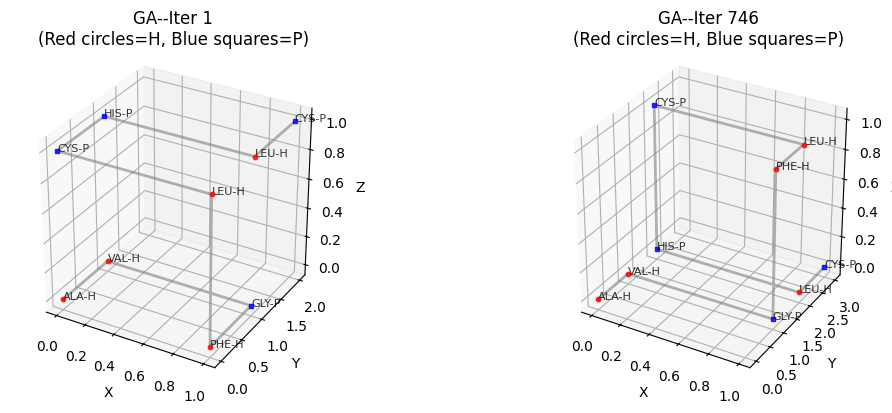


STEP 2b: Visualizing final optimized structure...


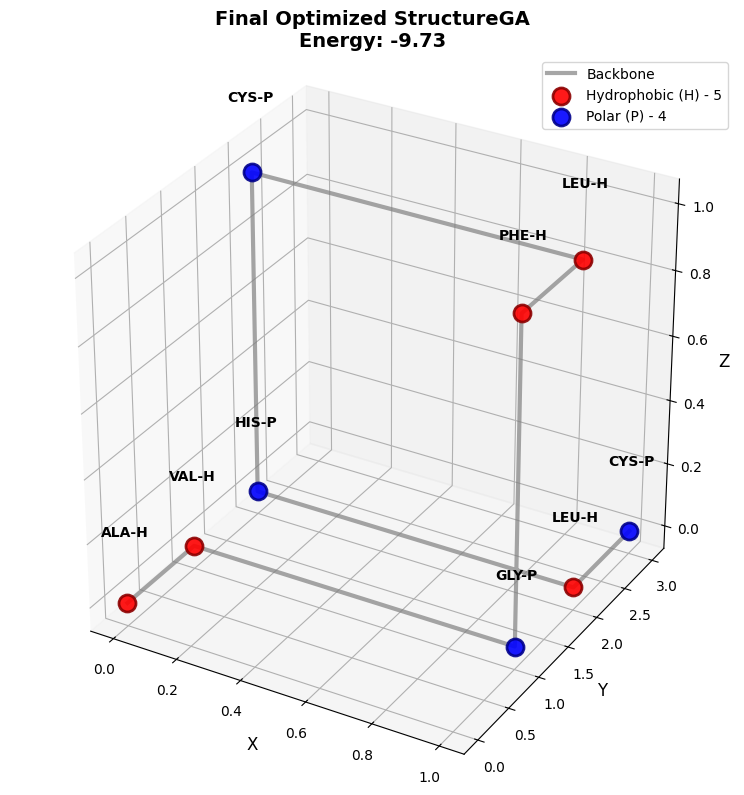


STEP 3a: Running Simulated Annealing optimization...
[(0, 0, 0), (0, 1, 0), (1, 1, 0), (1, 0, 0), (1, 0, 1), (0, 0, 1), (0, 1, 1), (1, 1, 1), (1, 2, 1)]
this is iteration0 for SImualted touching
valid position with lower energy found!
valid position with lower energy found!
Temp ITERATION0 for SImualted touching
The probability is:  1.0002800392036588
Move accepted with energy -9.73 at iteration 1
NEW BEST protein found with energy -9.73 at iteration 1
the best energy in iteration 1 is -9.73
this is iteration1 for SImualted touching
No valid position found with systematic approach, trying random sampling...
No valid position found with systematic approach, trying random sampling...
Temp ITERATION1 for SImualted touching
The probability is:  0.9960677516162023
Move accepted with energy -5.79 at iteration 2
the best energy in iteration 2 is -9.73
this is iteration2 for SImualted touching
valid position with lower energy found!
valid position with lower energy found!
Temp ITERATION2 for 

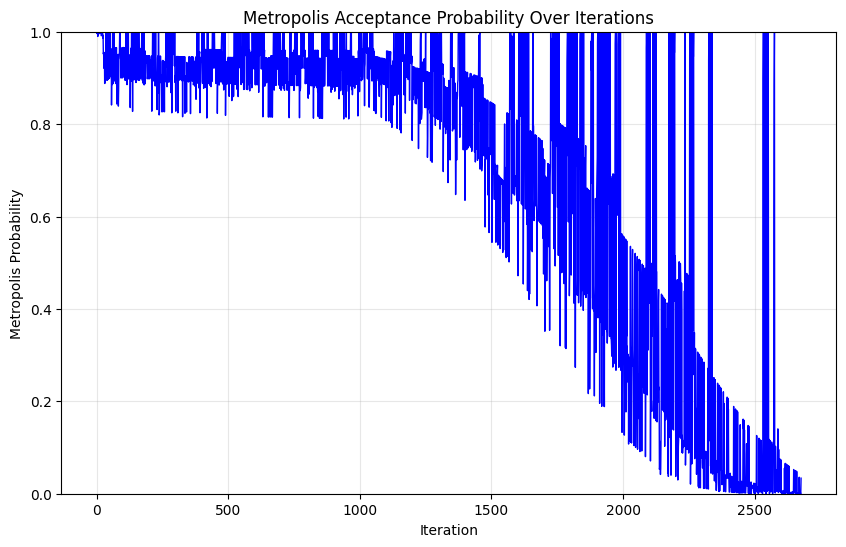

Initial energy: [np.float64(-9.45), np.float64(-9.73), np.float64(-5.79), np.float64(-6.1), np.float64(-6.66), np.float64(-9.73), np.float64(0.52), np.float64(-6.1), np.float64(-9.03), np.float64(-9.45), np.float64(-9.73), np.float64(-5.44), np.float64(-13.43), np.float64(-13.620000000000001), np.float64(-13.43), np.float64(-13.620000000000001), np.float64(-10.05), np.float64(-10.36), np.float64(-10.920000000000002), np.float64(-4.92), np.float64(-5.44), np.float64(-5.45), np.float64(-10.06), np.float64(-13.43), np.float64(-13.43), 0, np.float64(-6.1), np.float64(-9.45), np.float64(-9.73), np.float64(-6.66), np.float64(-9.45), np.float64(-9.73), np.float64(-3.57), np.float64(-3.58), np.float64(-4.62), np.float64(-6.67), np.float64(-8.18), np.float64(-13.43), np.float64(-13.620000000000001), np.float64(-8.18), np.float64(-13.620000000000001), np.float64(-4.19), np.float64(-10.05), np.float64(-13.43), np.float64(-13.620000000000001), np.float64(-4.380000000000001), np.float64(-5.23), np.

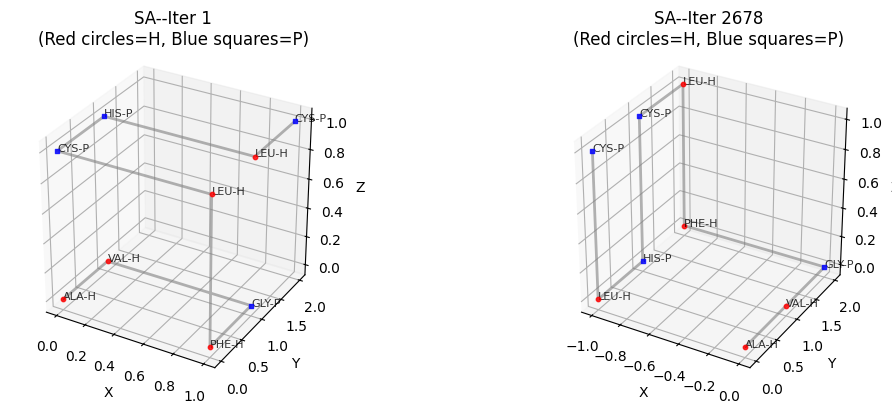


STEP 3b: Visualizing final optimized structure...


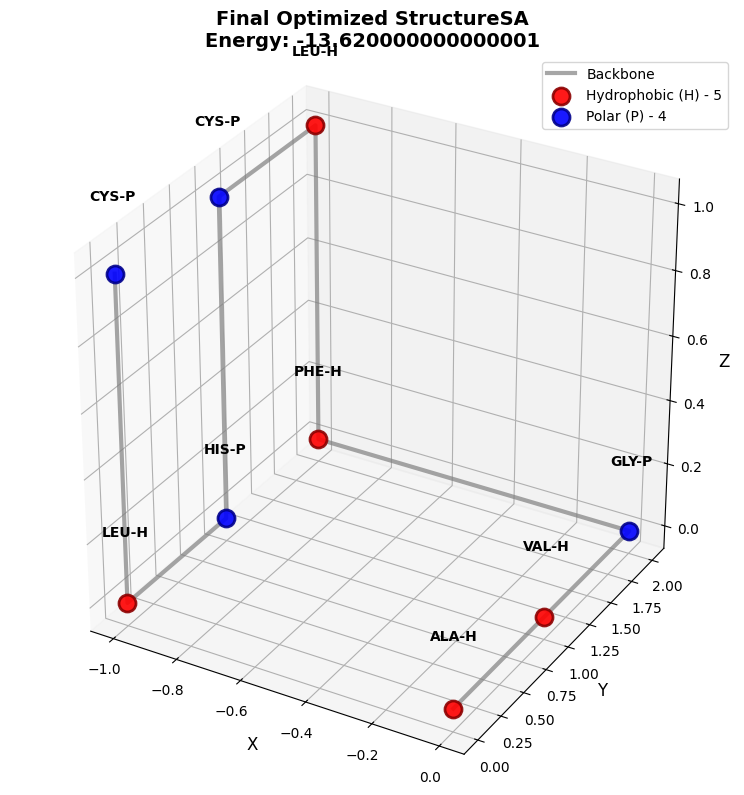


STEP 4a: Running Hill Climbing optimization...
[(0, 0, 0), (0, 1, 0), (1, 1, 0), (1, 0, 0), (1, 0, 1), (0, 0, 1), (0, 1, 1), (1, 1, 1), (1, 2, 1)]
Hill climbing starting with energy: -9.45
this is iteration0
valid position with lower energy found!
valid position with lower energy found!
best protein found with-9.73 with 1
shitty position in 1
this is iteration1
No valid position found with systematic approach, trying random sampling...
No valid position found with systematic approach, trying random sampling...
bruh this energy is -9.73 but the best is -9.73
shitty position in 2
this is iteration2
No valid position found with systematic approach, trying random sampling...
No valid position found with systematic approach, trying random sampling...
bruh this energy is -5.46 but the best is -9.73
shitty position in 3
this is iteration3
No valid position found with systematic approach, trying random sampling...
No valid position found with systematic approach, trying random sampling...
bru

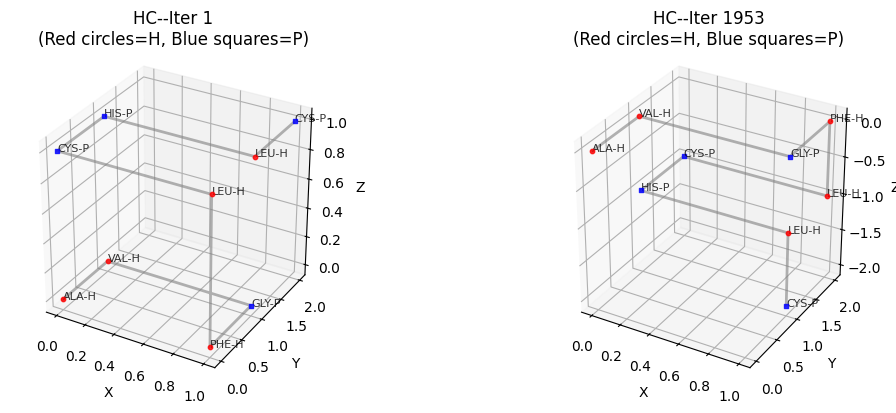


STEP 4b: Visualizing final optimized structure...


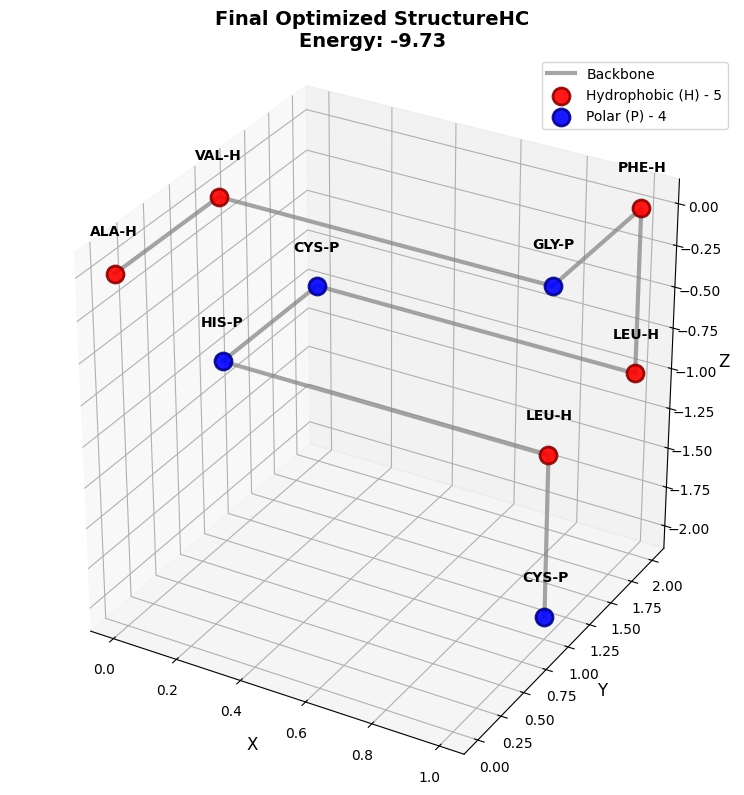


STEP 5a: Running Ant Colony optimization...
[(0, 0, 0), (0, 1, 0), (1, 1, 0), (1, 0, 0), (1, 0, 1), (0, 0, 1), (0, 1, 1), (1, 1, 1), (1, 2, 1)]
[INFO] ACO starting with 15 ants and 999999 iterations
[(0, 0, 0), (0, 1, 0), (1, 1, 0), (1, 0, 0), (1, 0, 1), (0, 0, 1), (0, 1, 1), (1, 1, 1), (1, 2, 1)]
[(0, 0, 0), (0, 1, 0), (1, 1, 0), (1, 0, 0), (1, 0, 1), (0, 0, 1), (0, 1, 1), (1, 1, 1), (1, 2, 1)]
[(0, 0, 0), (0, 1, 0), (1, 1, 0), (1, 0, 0), (1, 0, 1), (0, 0, 1), (0, 1, 1), (1, 1, 1), (1, 2, 1)]
[(0, 0, 0), (0, 1, 0), (1, 1, 0), (1, 0, 0), (1, 0, 1), (0, 0, 1), (0, 1, 1), (1, 1, 1), (1, 2, 1)]
[(0, 0, 0), (0, 1, 0), (1, 1, 0), (1, 0, 0), (1, 0, 1), (0, 0, 1), (0, 1, 1), (1, 1, 1), (1, 2, 1)]
[(0, 0, 0), (0, 1, 0), (1, 1, 0), (1, 0, 0), (1, 0, 1), (0, 0, 1), (0, 1, 1), (1, 1, 1), (1, 2, 1)]
[(0, 0, 0), (0, 1, 0), (1, 1, 0), (1, 0, 0), (1, 0, 1), (0, 0, 1), (0, 1, 1), (1, 1, 1), (1, 2, 1)]
[(0, 0, 0), (0, 1, 0), (1, 1, 0), (1, 0, 0), (1, 0, 1), (0, 0, 1), (0, 1, 1), (1, 1, 1), (1, 2, 1)]


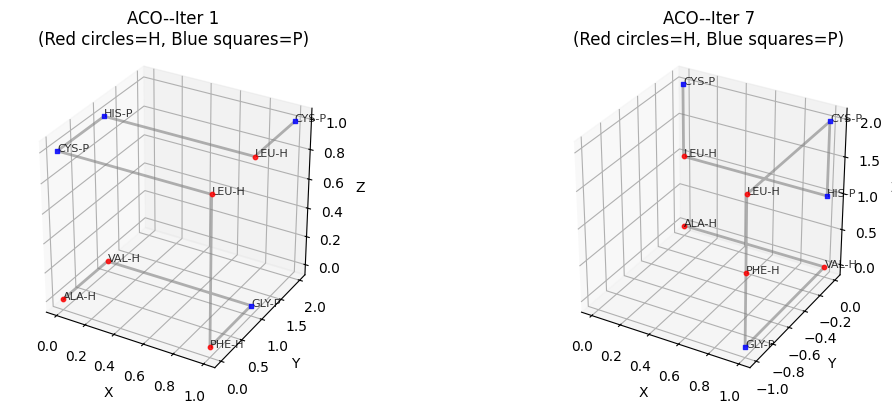


STEP 5b: Visualizing final optimized structure...


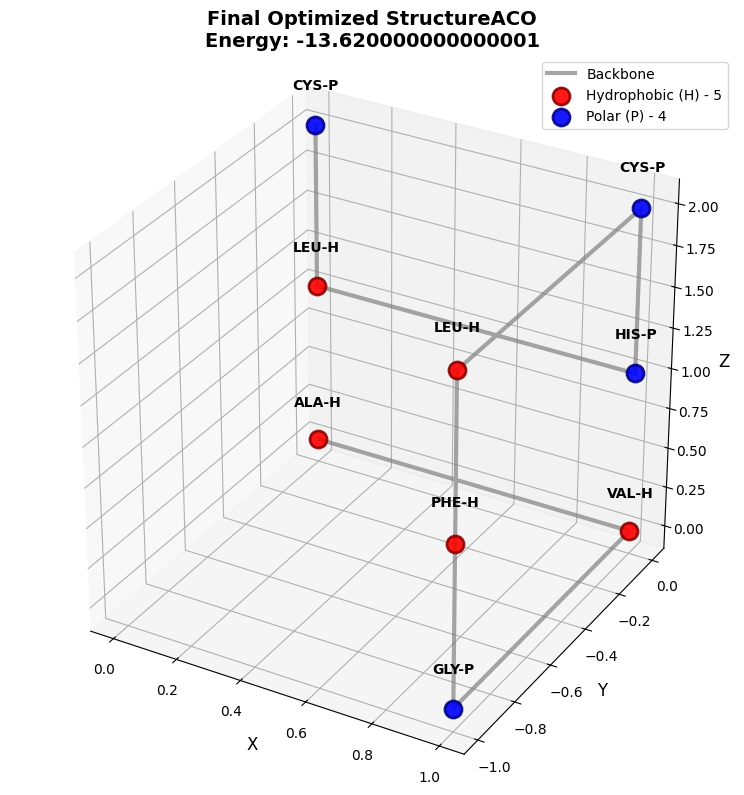

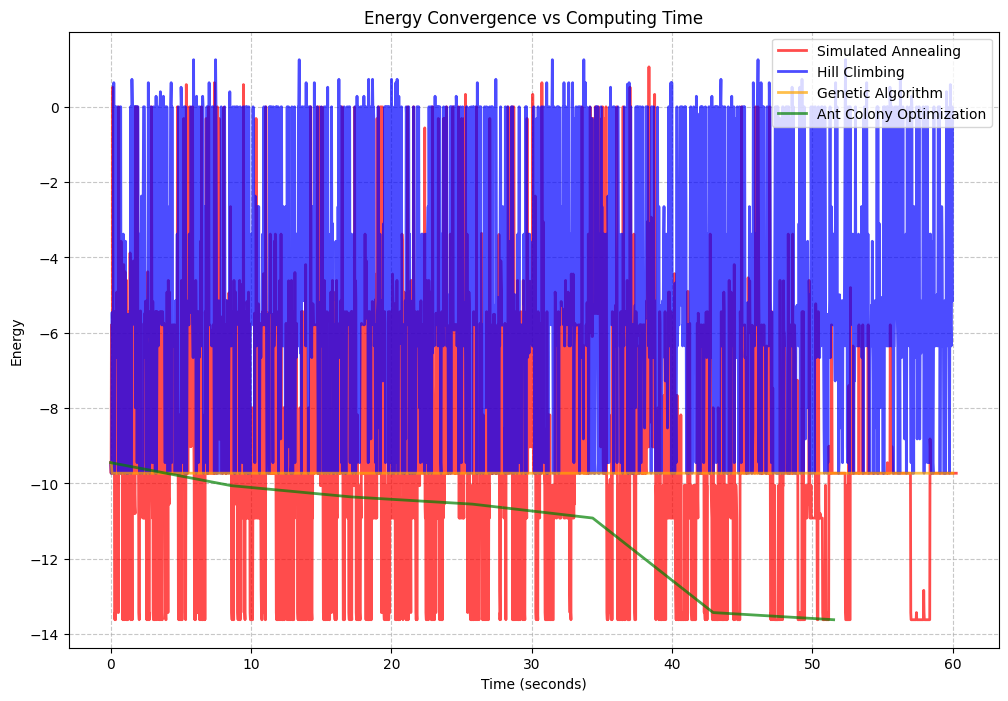

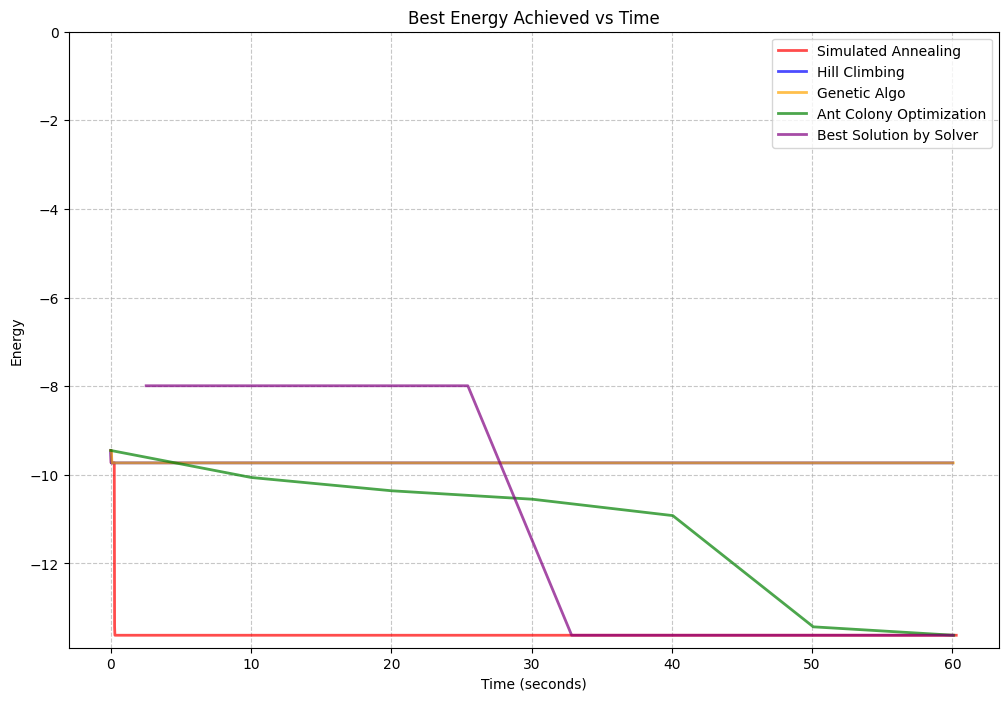

In [71]:
if __name__ == "__main__":
    
    print("\nSTEP 1: Loading protein sequence from PDB...")
    # Load HP sequence from PDB file
    hp_array, residue_chain = get_hp("2a3d.pdb")  # Replace with your PDB file
    print(f"HP sequence: {''.join(hp_array)}")
    print(f"Length: {len(hp_array)} amino acids")
    print(f"Hydrophobic (H): {sum(1 for aa in hp_array if aa == 'H')}")
    print(f"Polar (P): {sum(1 for aa in hp_array if aa == 'P')}")

    print("\nSTEP 2a: Running Genetic Algo optimization...")
    # Run simulated annealing  
    start_time = time.time()
    optimized_protein_ga, energy_history_ga, position_history_ga = genetic_algorithm(hp_array, residue_chain)
    ga_time = time.time() - start_time
    print(f"Initial energy: {energy_history_ga}")
    print(f"Final energy (SA): {optimized_protein_ga._energy}")
    print(f"Runtime: {ga_time:.2f} seconds")
    plot_first_and_last_iterations("GA", position_history_ga, hp_array, residue_chain)
    
    # Plot the final optimized structure
    print("\nSTEP 2b: Visualizing final optimized structure...")
    plot_protein_structure_3d("GA", optimized_protein_ga, "Final Optimized Structure")
    
    print("\nSTEP 3a: Running Simulated Annealing optimization...")
    # Run simulated annealing  
    start_time = time.time()
    optimized_protein_sa, energy_history_sa, position_history_sa = simulated_annealing(hp_array, residue_chain)
    sa_time = time.time() - start_time
    print(f"Initial energy: {energy_history_sa}")
    print(f"Final energy (SA): {optimized_protein_sa._energy}")
    print(f"Runtime: {sa_time:.2f} seconds")
    plot_first_and_last_iterations("SA", position_history_sa, hp_array, residue_chain)
    
    # Plot the final optimized structure
    print("\nSTEP 3b: Visualizing final optimized structure...")
    
    plot_protein_structure_3d("SA", optimized_protein_sa, "Final Optimized Structure")

    print("\nSTEP 4a: Running Hill Climbing optimization...")
    # RUN HILL CLIMBING
    start_time = time.time()
    optimized_protein_hc, energy_history_hc, position_history_hc = hill_climbing(hp_array, residue_chain)
    hc_time = time.time() - start_time
    print(f"Initial energy: {energy_history_hc[0]}")
    print(f"Final energy (HC): {optimized_protein_hc._energy}")
    print(f"Runtime: {hc_time:.2f} seconds")
    plot_first_and_last_iterations("HC", position_history_hc, hp_array, residue_chain)

    # Plot the final optimized structure
    print("\nSTEP 4b: Visualizing final optimized structure...")
    plot_protein_structure_3d("HC", optimized_protein_hc, "Final Optimized Structure")
    
    print("\nSTEP 5a: Running Ant Colony optimization...")
    # RUN ant colony
    start_time = time.time()
    optimized_protein_aco, position_history_aco, energy_history_aco = AntColonyOptimisation(hp_array, residue_chain)
    aco_time = time.time() - start_time
    print(f"Initial energy: {energy_history_aco[0]}")
    print(f"Final energy (ACO): {optimized_protein_aco._energy}")
    print(f"Runtime: {aco_time:.2f} seconds")
    plot_first_and_last_iterations("ACO", position_history_aco, hp_array, residue_chain)

    #plot the final optimized structure
    print("\nSTEP 5b: Visualizing final optimized structure...")
    plot_protein_structure_3d("ACO", optimized_protein_aco, "Final Optimized Structure")



    # Plot overlayed energy convergence vs time
    plt.figure(figsize=(12, 8))
    sa_times = [i * sa_time / len(energy_history_sa) for i in range(len(energy_history_sa))]
    hc_times = [i * hc_time / len(energy_history_hc) for i in range(len(energy_history_hc))]
    ga_times = [i * ga_time / len(energy_history_ga) for i in range(len(energy_history_ga))]
    aco_times = [i * aco_time / len(energy_history_aco) for i in range(len(energy_history_aco))]

    plt.plot(sa_times, energy_history_sa, label='Simulated Annealing', color='red', linewidth=2, alpha=0.7)
    plt.plot(hc_times, energy_history_hc, label='Hill Climbing', color='blue', linewidth=2, alpha=0.7)
    plt.plot(ga_times, energy_history_ga, label='Genetic Algorithm', color='orange', linewidth=2, alpha=0.7)
    plt.plot(aco_times, energy_history_aco, label='Ant Colony Optimization', color='green', linewidth=2, alpha=0.7)

    plt.title("Energy Convergence vs Computing Time")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Energy")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    plt.figure(figsize=(12, 8))

    # Calculate cumulative minima
    best_energy_sa = np.minimum.accumulate(energy_history_sa)
    best_energy_hc = np.minimum.accumulate(energy_history_hc)
    best_energy_ga = np.minimum.accumulate(energy_history_ga)
    best_energy_aco = np.minimum.accumulate(energy_history_aco)


    # Time normalization
    sa_times_final = np.linspace(0, sa_time, len(energy_history_sa))
    hc_times_final = np.linspace(0, hc_time, len(energy_history_hc))
    ga_times_final = np.linspace(0, ga_time, len(energy_history_ga))
    aco_times_final = np.linspace(0, aco_time, len(energy_history_aco))

    plt.plot(sa_times_final, best_energy_sa, label='Simulated Annealing', alpha=0.7, color='red', linewidth=2)
    plt.plot(hc_times_final, best_energy_hc, label='Hill Climbing', alpha=0.7, color='blue', linewidth=2)
    plt.plot(ga_times_final, best_energy_ga, label='Genetic Algo', alpha=0.7, color='orange', linewidth=2)
    plt.plot(aco_times_final, best_energy_aco, label='Ant Colony Optimization', alpha=0.7, color='green', linewidth=2)
    plt.plot(times, obj_vals, label="Best Solution by Solver", alpha=0.7, color='purple', linewidth=2)

    plt.title("Best Energy Achieved vs Time")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Energy")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.ylim(top=0)  # Set y-axis limit to start from 0
    plt.show()
    
    # plot original, comment out IN THIS FILE
    # plot_original_pdb("2a3d.pdb")